In [147]:
# preprocessing
import pandas as pd
import numpy as np
import time
from tqdm import tqdm
from scipy.stats import skew

# plot!
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.font_manager as fm
import seaborn as sns
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = (10, 5)
font_path = 'c:/Windows/Fonts/malgun.ttf'
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)
#한글 폰트 설정
plt.rcParams['axes.unicode_minus'] = False
#ticks에 적용될 한글 폰트
font_ticks = fm.FontProperties(fname=font_path, size=10)
#title에 적용될 한글 폰트
font_title = fm.FontProperties(fname=font_path, size=13)

# for model
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from scipy import stats

from sklearn.tree import DecisionTreeClassifier
# from sklearn import tree
# from sklearn.tree import export_graphviz
# import graphviz

from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# metric
import eli5 
from eli5.sklearn import PermutationImportance 
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import average_precision_score, precision_recall_curve, plot_precision_recall_curve, f1_score 

In [ ]:
pd.set_option('display.max_columns', None)

In [45]:
train_dat = pd.read_csv('./data/train_dat.csv')
val_dat = pd.read_csv('./data/val_dat.csv')
dat_train = pd.read_csv('./data/dat_train.csv')
dat_test = pd.read_csv('./data/dat_test.csv')

In [46]:
train_dat.head()

,media_name,abstractive,extractive,article_len,ext_len,ext_1st,ext_2nd,ext_3rd,id,article_sent,...,first,bias,bias_1,bias_2,bias_3,article_token,SL,perc,TF_ISF,sent2sim
0,중부일보,['인천 서구청 김진삼 청원경찰이 근무 하던 중 횡단보도에서 거동이 불편한 80대 ...,"[2, 3, 5]",11,3,2,3,5,7659,조현진 이재현 서구청장(오른쪽)이 선행을 베푼 김진삼 서구청 청원경찰에게 표창장을 ...,...,1,0.02,0.06,0.00,0.00,"['조현진', '이재현', '서구', '청장', '오른쪽', '선행', '김진삼',...",0.739130,0.0,0.454083,0.184745
1,중부일보,['인천 서구청 김진삼 청원경찰이 근무 하던 중 횡단보도에서 거동이 불편한 80대 ...,"[2, 3, 5]",11,3,2,3,5,7659,사진=서구청,...,0,0.17,0.42,0.04,0.02,"['사진', '서구', '청']",0.130435,0.1,0.055564,0.158663
2,중부일보,['인천 서구청 김진삼 청원경찰이 근무 하던 중 횡단보도에서 거동이 불편한 80대 ...,"[2, 3, 5]",11,3,2,3,5,7659,실종된 치매 어르신을 가족들 품에 안전하게 돌려보낸 인천 서구청 청원경찰의 미담(중...,...,0,0.21,0.29,0.27,0.06,"['실종', '치매', '어르신', '가족', '품', '안전', '하', '인천'...",1.000000,0.2,0.670845,0.205166
3,중부일보,['인천 서구청 김진삼 청원경찰이 근무 하던 중 횡단보도에서 거동이 불편한 80대 ...,"[2, 3, 5]",11,3,2,3,5,7659,서구는 선행을 베푼 김진삼 청원경찰에게 표창장을 수여했다고 11일 밝혔다.,...,0,0.18,0.14,0.25,0.14,"['서구', '선행', '김진삼', '청원경찰', '표창장', '수여']",0.260870,0.3,0.184990,0.221849
4,중부일보,['인천 서구청 김진삼 청원경찰이 근무 하던 중 횡단보도에서 거동이 불편한 80대 ...,"[2, 3, 5]",11,3,2,3,5,7659,"이재현 서구청장은 이날 수여식에서 ""평소 투철한 봉사 정신과 이웃을 사랑하는 마음으...",...,0,0.13,0.05,0.17,0.18,"['이재현', '서구', '청장', '이날', '수여식', '평소', '봉사', '...",0.869565,0.4,0.502019,0.208044


In [47]:
train_dat.drop(['abstractive','extractive','ext_len','article_sent',
                          'ext_1st', 'ext_2nd', 'ext_3rd', 'article_token', 'label'], axis=1) #필요한 피처 제외 모두 drop

,media_name,article_len,id,first,bias,bias_1,bias_2,bias_3,SL,perc,TF_ISF,sent2sim
0,중부일보,11,7659,1,0.02,0.06,0.00,0.00,0.739130,0.0000,0.454083,0.184745
1,중부일보,11,7659,0,0.17,0.42,0.04,0.02,0.130435,0.1000,0.055564,0.158663
2,중부일보,11,7659,0,0.21,0.29,0.27,0.06,1.000000,0.2000,0.670845,0.205166
3,중부일보,11,7659,0,0.18,0.14,0.25,0.14,0.260870,0.3000,0.184990,0.221849
4,중부일보,11,7659,0,0.13,0.05,0.17,0.18,0.869565,0.4000,0.502019,0.208044
...,...,...,...,...,...,...,...,...,...,...,...,...
98203,머니투데이,7,6882,0,0.20,0.11,0.26,0.26,0.533333,0.1579,0.362183,0.139670
98204,머니투데이,7,6882,0,0.12,0.04,0.14,0.23,0.433333,0.2105,0.349388,0.138982
98205,머니투데이,7,6882,0,0.08,0.01,0.10,0.16,1.000000,0.2632,0.585797,0.124758
98206,머니투데이,7,6882,0,0.05,0.01,0.05,0.13,0.700000,0.3158,0.491999,0.128484


In [48]:
# split X and y
train_y = train_dat.loc[:, 'label']
train_x = train_dat.drop(['abstractive','extractive','ext_len','article_sent',
                          'ext_1st', 'ext_2nd', 'ext_3rd', 'article_token', 'label'], axis=1) 
val_y = val_dat.loc[:, 'label']
val_x = val_dat.drop(['abstractive','extractive','ext_len','article_sent',
                          'ext_1st', 'ext_2nd', 'ext_3rd', 'article_token', 'label'], axis=1) 

Y_train = dat_train.loc[:, 'label']
X_train = dat_train.drop(['abstractive','extractive','ext_len','article_sent',
                          'ext_1st', 'ext_2nd', 'ext_3rd', 'article_token', 'label'], axis=1) 

Y_test = dat_test.loc[:, 'label']
X_test = dat_test.drop(['abstractive','extractive','ext_len','article_sent',
                          'ext_1st', 'ext_2nd', 'ext_3rd', 'article_token', 'label'], axis=1) 

In [8]:
X_train.columns

Index(['media_name', 'article_len', 'id', 'first', 'bias', 'bias_1', 'bias_2',
       'bias_3', 'SL', 'perc', 'TF_ISF', 'sent2sim'],
      dtype='object')

0it [00:00, ?it/s]c:\users\user\miniconda3\envs\jjtensor\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
1it [00:00,  1.51it/s]c:\users\user\miniconda3\envs\jjtensor\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
2it [00:01,  1.59it/s]c:\users\user\miniconda3\envs\jjtensor\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Pl

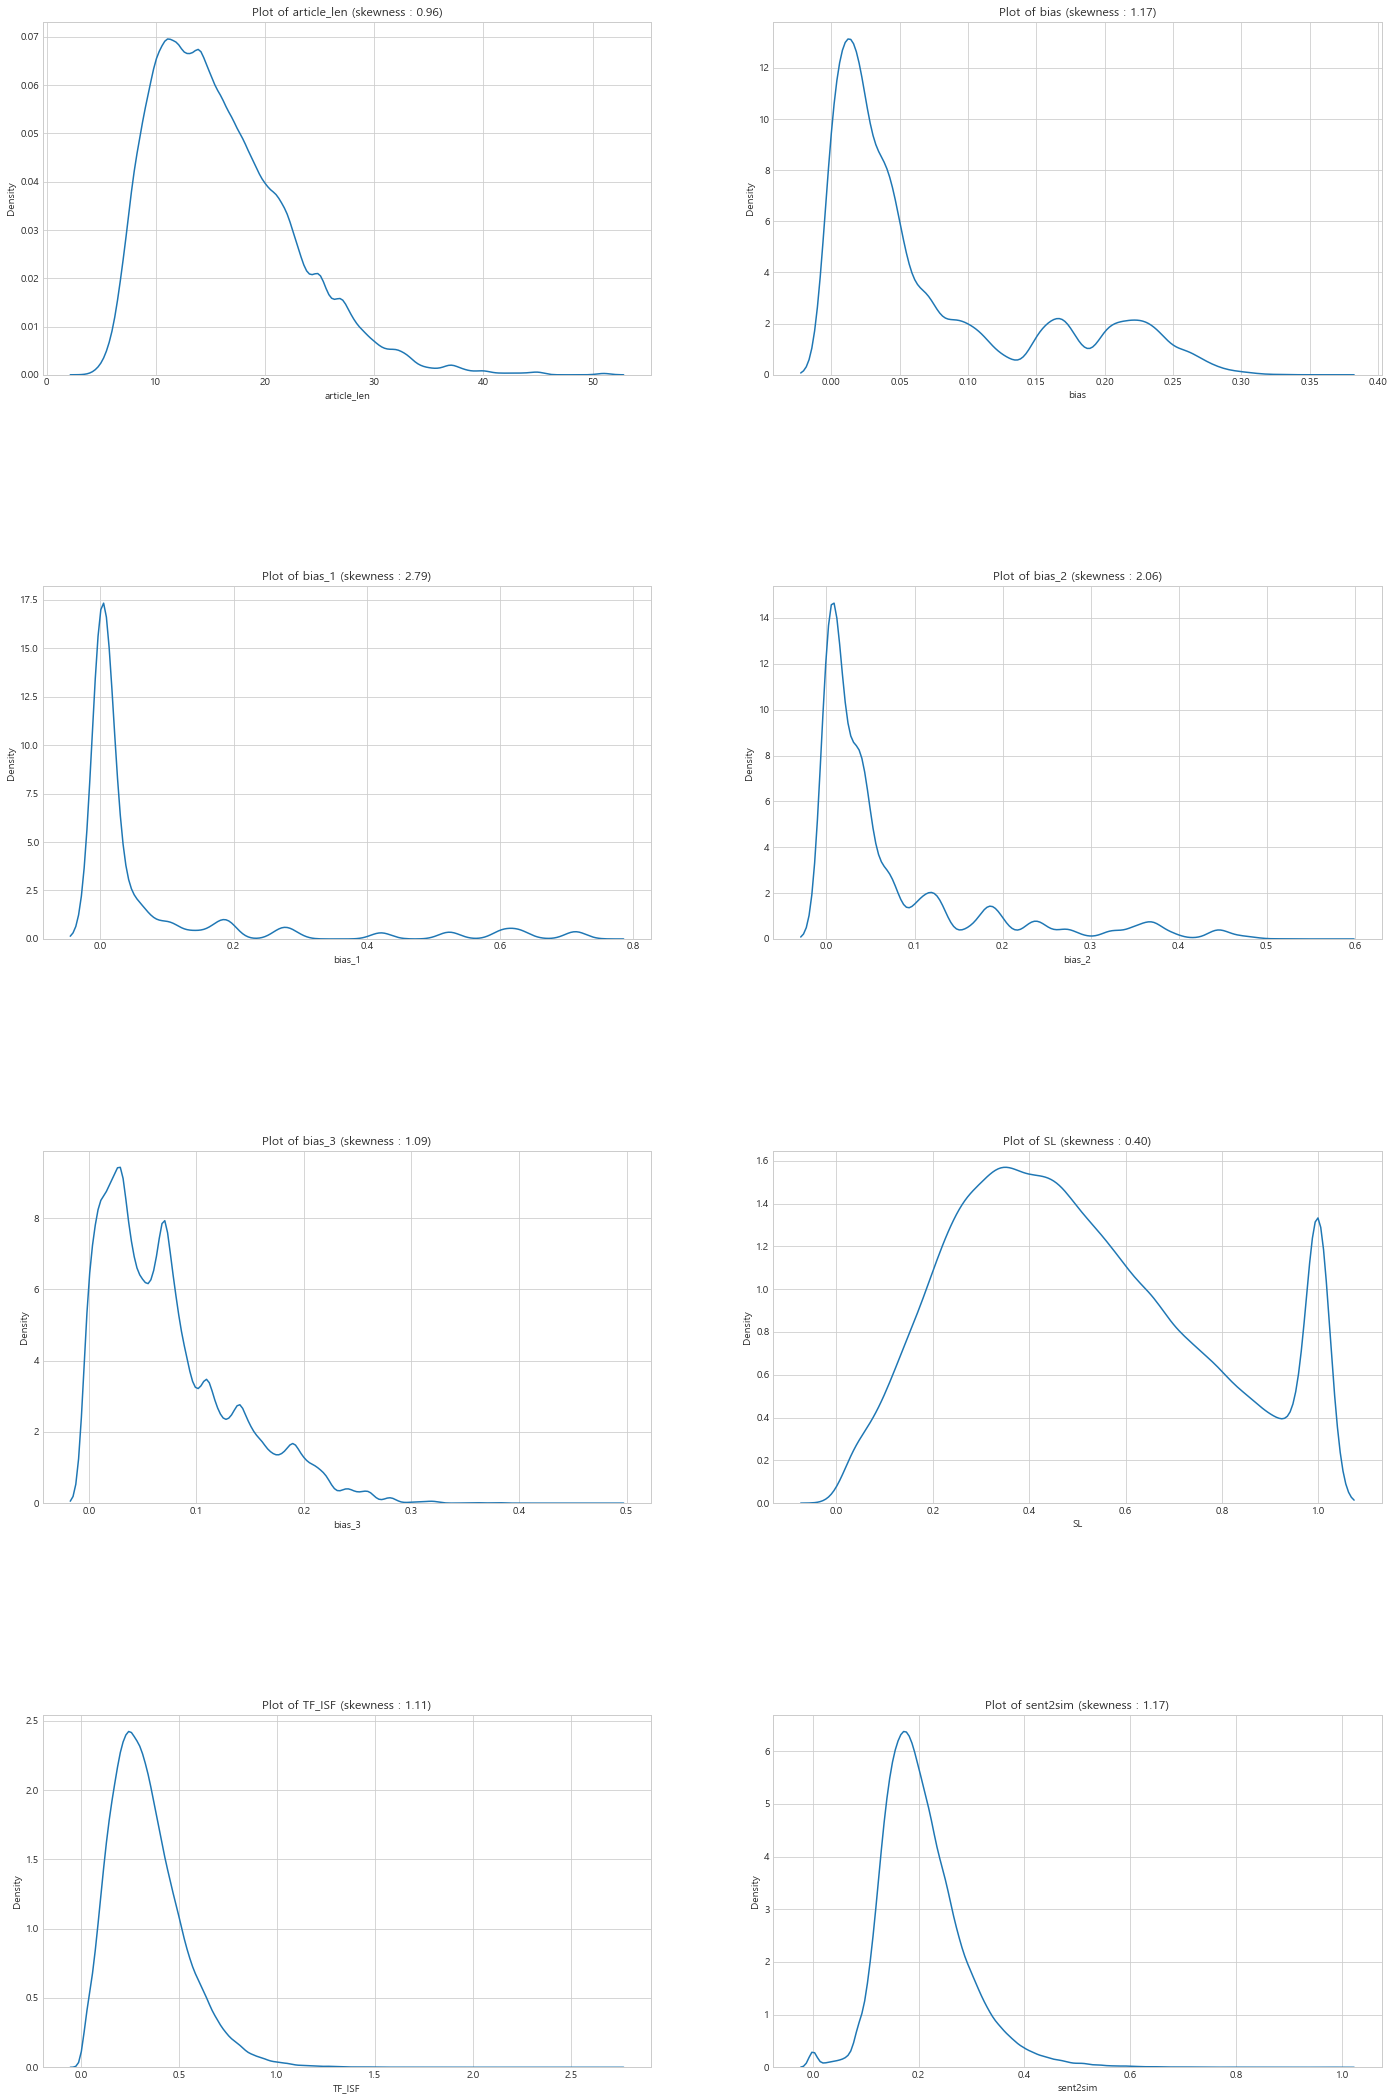

In [6]:
from scipy.stats import skew

conti_list = ['article_len', 'bias', 'bias_1', 'bias_2', 'bias_3',
              'SL', 'TF_ISF', 'sent2sim']

fig = plt.figure(figsize= (24, 8*6))
for i, col in tqdm(enumerate(conti_list)):
    plt.subplot(5, 2, i+1)
    plt.subplots_adjust(wspace=0.2, hspace=0.6)
    sns.distplot(X_train[col], hist = False, kde = True)
    plt.title( 'Plot of %s (skewness : %.2f)'%(col, skew(X_train[col])) )

## MODEL

In [49]:
Y_train.value_counts(normalize=True)

0    0.78397
1    0.21603
Name: label, dtype: float64

In [50]:
X_train.head()

,media_name,article_len,id,first,bias,bias_1,bias_2,bias_3,SL,perc,TF_ISF,sent2sim
0,매일경제,13,4161,1,0.25,0.63,0.07,0.03,0.370370,0.0000,0.256849,0.152836
1,매일경제,13,4161,0,0.22,0.19,0.37,0.07,0.296296,0.0833,0.171990,0.310756
2,매일경제,13,4161,0,0.15,0.08,0.18,0.20,0.814815,0.1667,0.705565,0.181595
3,매일경제,13,4161,0,0.10,0.03,0.12,0.15,0.333333,0.2500,0.357998,0.290310
4,매일경제,13,4161,0,0.07,0.02,0.07,0.12,0.111111,0.3333,0.107355,0.160858


In [51]:
X_train['media_name'].unique().tolist()

['매일경제', '디지털타임스', '머니투데이', '중부일보', '아주경제']

In [52]:
# replace_dict = {'매일경제' : '1',
#                 '디지털타임스' : '2',
#                 '머니투데이' : '3',
#                 '중부일보' : '4',
#                 '아주경제' : '5'}

# X_train['media_name'] = X_train['media_name'].replace(replace_dict)
# X_test['media_name'] = X_test['media_name'].replace(replace_dict)

In [53]:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
train_x = pd.get_dummies(train_x)
val_x = pd.get_dummies(val_x)

In [54]:
# 'media_name_디지털타임스'는 drop or not
cat_list = ['media_name_디지털타임스', 'media_name_매일경제', 'media_name_머니투데이',
            'media_name_아주경제', 'media_name_중부일보']
conti_list = [col for col in X_train.columns if col not in cat_list]

for cat in cat_list:
    X_train[cat] = X_train[cat].astype('category')
    X_test[cat] = X_test[cat].astype('category')
    train_x[cat] = train_x[cat].astype('category')
    val_x[cat] = val_x[cat].astype('category')


In [2]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

X_train_scaled = pd.DataFrame(ss.fit_transform(X_train[conti_list]), columns = conti_list)
X_train_scaled = pd.concat([X_train_scaled, X_train[cat_list]], axis=1)

X_test_scaled = pd.DataFrame(ss.transform(X_test[conti_list]), columns = conti_list)
X_test_scaled = pd.concat([X_test_scaled, X_test[cat_list]], axis=1)

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

train_x_scaled = pd.DataFrame(ss.fit_transform(train_x[conti_list]), columns = conti_list)
train_x_scaled = pd.concat([train_x_scaled, train_x[cat_list]], axis=1)

val_x_scaled = pd.DataFrame(ss.transform(val_x[conti_list]), columns = conti_list)
val_x_scaled = pd.concat([val_x_scaled, val_x[cat_list]], axis=1)

In [58]:
# variable importance ( n_iter=5 )
lr = LogisticRegression()
lr.fit(X_train, Y_train)
perm = PermutationImportance(lr, scoring = "f1", random_state = 42).fit(X_test, Y_test)
eli5.show_weights(perm, top = 16, feature_names = X_test.columns.tolist())

Weight,Feature
0.2459 ± 0.0077,bias_1
0.1608 ± 0.0046,bias_2
0.0843 ± 0.0070,bias
0.0157 ± 0.0022,article_len
0.0139 ± 0.0031,SL
0.0131 ± 0.0030,media_name_매일경제
0.0095 ± 0.0024,TF_ISF
0.0073 ± 0.0040,media_name_디지털타임스
0.0072 ± 0.0024,media_name_아주경제
0.0064 ± 0.0009,bias_3


In [77]:
def logistic_cv(X_train, X_test, y_train, y_test):
    
    X_train = X_train.drop(['id', 'media_name_중부일보'], axis=1)
    X_test_id = X_test['id']
    X_test = X_test.drop(['id', 'media_name_중부일보'], axis=1)
    
    param_grid_logistic={'C':[1e-2, 1e-1, 1, 1e1, 1e2]}
    logistic_cv = GridSearchCV(LogisticRegression(penalty = 'l2', max_iter=500), param_grid_logistic,
                               cv=5, scoring = 'roc_auc', verbose=2)
    logistic_cv.fit(X_train,y_train)
    model = sm.Logit(y_train, X_train)
    mod = model.fit()
    print(mod.summary())
    print(logistic_cv.best_params_)
    
    # make top 3 prob : 1 / others : 0
    #     logistic_test=logistic_cv.predict(X_test)
    logistic_test_prob = logistic_cv.predict_proba(X_test)[:,1]
    logistic_test_prob = pd.concat([X_test_id, pd.DataFrame(logistic_test_prob)], axis=1)
    logistic_test_prob.columns = ['id','pred']
    
    one_list = list()
    id_list = logistic_test_prob['id'].unique().tolist()
    for idd in tqdm(id_list):
        sample = logistic_test_prob.loc[logistic_test_prob['id'] == idd]
        one_index = sample.sort_values(by='pred', ascending=False)[:3].index.tolist()
        for ind in one_index:
            one_list.append(ind)
            
    logistic_test_prob.loc[logistic_test_prob.index.isin(one_list), 'pred'] = 1
    logistic_test_prob.loc[~logistic_test_prob.index.isin(one_list), 'pred'] = 0
    logistic_test = np.array(logistic_test_prob['pred'])
    
     # F1 score
    precision, recall, thresholds = precision_recall_curve(y_test, logistic_test)
    auc_precision_recall = auc(recall, precision)
    print("Test:\n", "Precision score / Recall Score / F1 score(micro) / F1 score(macro) / PR-AUC / ROC-AUC \n",
          round(precision_score(y_test,logistic_test, pos_label = 1),5),'         /' ,
          round(recall_score(y_test,logistic_test, pos_label = 1),5),'         /' ,
          round(f1_score(y_test,logistic_test, average="micro"),5),'         /' ,
          round(f1_score(y_test,logistic_test, average="macro"),5),'  /' ,
          round(auc_precision_recall,5), '    /' ,
          round(roc_auc_score(y_test,logistic_test),5))
    
#     # F1 score
#     precision, recall, thresholds = precision_recall_curve(y_test, logistic_test)
#     auc_precision_recall = auc(recall, precision)
#     print("Test:\n","F1 score(micro) / F1 score(macro) / PR-AUC / ROC-AUC \n",round(f1_score(y_test,logistic_test, average="micro"),5),'         /' ,
#           round(f1_score(y_test,logistic_test, average="macro"),5),'  /' ,
#           round(auc_precision_recall,5), '    /' ,round(roc_auc_score(y_test,logistic_test),5))
    
    # confusion matrix
    test_confusion_matrix=confusion_matrix(y_test, logistic_test)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    test_confusion_matrix.flatten()]
    labels = [f'{v1}\n{v2}' for v1, v2 in
              zip(group_names,group_counts)]
    labels = np.asarray(labels).reshape(2,2)
    print("Test confusion matrix")
    print('TEST ACCURACY : %.2f'%(np.mean(Y_test == logistic_test)))
    sns.heatmap(test_confusion_matrix, annot=labels, fmt='', cmap="Blues",cbar=False,
                xticklabels=['Pred:N', 'Pred:P'], yticklabels=['Actual:N', 'Actual:P'])
    
    # ROC curve
    fig = plt.figure(figsize = (12, 7))
    fper, tper, thresholds = roc_curve(y_test, logistic_test)
    plt.plot(fper, tper, color='blue', label='Logistic')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (AUC : %.2f)'%(round(roc_auc_score(y_test,logistic_test),3)))
    plt.legend()

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........................................... C=0.01, total=   1.0s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] ........................................... C=0.01, total=   1.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.9s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.7s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.8s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   1.5s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   1.3s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   1.7s
[CV] C=0.1 ...........................................................
[CV] .

c:\users\user\miniconda3\envs\jjtensor\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] ........................................... C=10.0, total=   3.2s
[CV] C=10.0 ..........................................................
[CV] ........................................... C=10.0, total=   2.9s
[CV] C=10.0 ..........................................................
[CV] ........................................... C=10.0, total=   2.6s
[CV] C=100.0 .........................................................
[CV] .......................................... C=100.0, total=   2.8s
[CV] C=100.0 .........................................................
[CV] .......................................... C=100.0, total=   2.6s
[CV] C=100.0 .........................................................
[CV] .......................................... C=100.0, total=   2.7s
[CV] C=100.0 .........................................................
[CV] .......................................... C=100.0, total=   3.0s
[CV] C=100.0 .........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   50.1s finished
c:\users\user\miniconda3\envs\jjtensor\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Optimization terminated successfully.
         Current function value: 0.415726
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  label   No. Observations:               122474
Model:                          Logit   Df Residuals:                   122460
Method:                           MLE   Df Model:                           13
Date:                Thu, 16 Dec 2021   Pseudo R-squ.:                  0.2033
Time:                        13:28:23   Log-Likelihood:                -50916.
converged:                       True   LL-Null:                       -63911.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
article_len          -0.1128      0.002    -62.969      0.000      -0.116      -0.109
first   

100%|████████████████████████████████████████████████████████████████████████████| 2206/2206 [00:02<00:00, 1102.93it/s]


Test:
 Precision score / Recall Score / F1 score(micro) / F1 score(macro) / PR-AUC / ROC-AUC 
 0.59202          / 0.59211          / 0.82345          / 0.73971   / 0.6362     / 0.73972
Test confusion matrix
TEST ACCURACY : 0.82


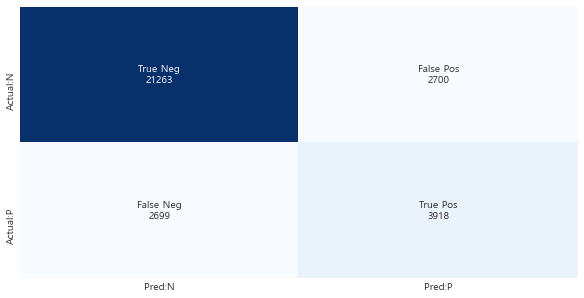

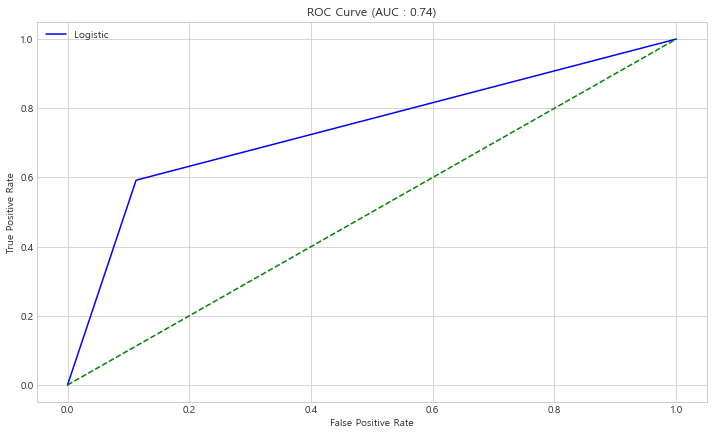

In [78]:
logistic_cv(X_train, X_test, Y_train, Y_test)

In [61]:
# variable importance
dt = DecisionTreeClassifier()
dt.fit(X_train, Y_train)
perm = PermutationImportance(dt, scoring = "f1", random_state = 42).fit(X_test, Y_test)
eli5.show_weights(perm, top = 16, feature_names = X_test.columns.tolist())

Weight,Feature
0.1682 ± 0.0047,bias
0.0399 ± 0.0086,TF_ISF
0.0379 ± 0.0032,article_len
0.0325 ± 0.0088,SL
0.0240 ± 0.0020,bias_1
0.0225 ± 0.0029,bias_3
0.0191 ± 0.0047,sent2sim
0.0108 ± 0.0018,bias_2
0.0023 ± 0.0009,media_name_디지털타임스
0.0022 ± 0.0022,perc


In [73]:
def DT_cv(X_train, X_test, y_train, y_test):
    
    X_train = X_train.drop(['id'], axis=1)
    X_test_id = X_test['id']
    X_test = X_test.drop(['id'], axis=1)
    param_grid_DT={'criterion': ['gini', 'entropy'], 'min_samples_leaf' : [1,2,3,4], 'max_depth': [2,3,4,6,8]}
    DT_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_DT,
                               cv=5, scoring = 'roc_auc', verbose=2)
    DT_cv.fit(X_train,y_train)
    print(DT_cv.best_params_)
    
    # make top 3 prob : 1 / others : 0
    DT_test_prob = DT_cv.predict_proba(X_test)[:,1]
    DT_test_prob = pd.concat([X_test_id, pd.DataFrame(DT_test_prob)], axis=1)
    DT_test_prob.columns = ['id','pred']
    
    one_list = list()
    id_list = DT_test_prob['id'].unique().tolist()
    for idd in tqdm(id_list):
        sample = DT_test_prob.loc[DT_test_prob['id'] == idd]
        one_index = sample.sort_values(by='pred', ascending=False)[:3].index.tolist()
        for ind in one_index:
            one_list.append(ind)
            
    DT_test_prob.loc[DT_test_prob.index.isin(one_list), 'pred'] = 1
    DT_test_prob.loc[~DT_test_prob.index.isin(one_list), 'pred'] = 0
    DT_test = np.array(DT_test_prob['pred'])
    
    # F1 score
    precision, recall, thresholds = precision_recall_curve(y_test, DT_test)
    auc_precision_recall = auc(recall, precision)
    print("Test:\n", "Precision score / Recall Score / F1 score(micro) / F1 score(macro) / PR-AUC / ROC-AUC \n",
          round(precision_score(y_test,DT_test, pos_label = 1),5),'         /' ,
          round(recall_score(y_test,DT_test, pos_label = 1),5),'         /' ,
          round(f1_score(y_test,DT_test, average="micro"),5),'         /' ,
          round(f1_score(y_test,DT_test, average="macro"),5),'  /' ,
          round(auc_precision_recall,5), '    /' ,
          round(roc_auc_score(y_test,DT_test),5))
    
    # confusion matrix
    test_confusion_matrix=confusion_matrix(y_test, DT_test)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    test_confusion_matrix.flatten()]
    labels = [f'{v1}\n{v2}' for v1, v2 in
              zip(group_names,group_counts)]
    labels = np.asarray(labels).reshape(2,2)
    print("Test confusion matrix")
    print('TEST ACCURACY : %.2f'%(np.mean(Y_test == DT_test)))
    sns.heatmap(test_confusion_matrix, annot=labels, fmt='', cmap="Blues",cbar=False,
                xticklabels=['Pred:N', 'Pred:P'], yticklabels=['Actual:N', 'Actual:P'])
    
    # ROC curve
    fig = plt.figure(figsize = (12, 7))
    fper, tper, thresholds = roc_curve(y_test, DT_test)
    plt.plot(fper, tper, color='blue', label='DT')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (AUC : %.2f)'%(round(roc_auc_score(y_test,DT_test),3)))
    plt.legend()

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] criterion=gini, max_depth=2, min_samples_leaf=1 .................
[CV] .. criterion=gini, max_depth=2, min_samples_leaf=1, total=   0.1s
[CV] criterion=gini, max_depth=2, min_samples_leaf=1 .................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .. criterion=gini, max_depth=2, min_samples_leaf=1, total=   0.1s
[CV] criterion=gini, max_depth=2, min_samples_leaf=1 .................
[CV] .. criterion=gini, max_depth=2, min_samples_leaf=1, total=   0.1s
[CV] criterion=gini, max_depth=2, min_samples_leaf=1 .................
[CV] .. criterion=gini, max_depth=2, min_samples_leaf=1, total=   0.1s
[CV] criterion=gini, max_depth=2, min_samples_leaf=1 .................
[CV] .. criterion=gini, max_depth=2, min_samples_leaf=1, total=   0.1s
[CV] criterion=gini, max_depth=2, min_samples_leaf=2 .................
[CV] .. criterion=gini, max_depth=2, min_samples_leaf=2, total=   0.1s
[CV] criterion=gini, max_depth=2, min_samples_leaf=2 .................
[CV] .. criterion=gini, max_depth=2, min_samples_leaf=2, total=   0.1s
[CV] criterion=gini, max_depth=2, min_samples_leaf=2 .................
[CV] .. criterion=gini, max_depth=2, min_samples_leaf=2, total=   0.1s
[CV] criterion=gini, max_depth=2, min_samples_leaf=2 .................
[CV] .

[CV] .. criterion=gini, max_depth=4, min_samples_leaf=4, total=   0.2s
[CV] criterion=gini, max_depth=6, min_samples_leaf=1 .................
[CV] .. criterion=gini, max_depth=6, min_samples_leaf=1, total=   0.3s
[CV] criterion=gini, max_depth=6, min_samples_leaf=1 .................
[CV] .. criterion=gini, max_depth=6, min_samples_leaf=1, total=   0.3s
[CV] criterion=gini, max_depth=6, min_samples_leaf=1 .................
[CV] .. criterion=gini, max_depth=6, min_samples_leaf=1, total=   0.3s
[CV] criterion=gini, max_depth=6, min_samples_leaf=1 .................
[CV] .. criterion=gini, max_depth=6, min_samples_leaf=1, total=   0.3s
[CV] criterion=gini, max_depth=6, min_samples_leaf=1 .................
[CV] .. criterion=gini, max_depth=6, min_samples_leaf=1, total=   0.3s
[CV] criterion=gini, max_depth=6, min_samples_leaf=2 .................
[CV] .. criterion=gini, max_depth=6, min_samples_leaf=2, total=   0.3s
[CV] criterion=gini, max_depth=6, min_samples_leaf=2 .................
[CV] .

[CV]  criterion=entropy, max_depth=2, min_samples_leaf=4, total=   0.1s
[CV] criterion=entropy, max_depth=2, min_samples_leaf=4 ..............
[CV]  criterion=entropy, max_depth=2, min_samples_leaf=4, total=   0.1s
[CV] criterion=entropy, max_depth=2, min_samples_leaf=4 ..............
[CV]  criterion=entropy, max_depth=2, min_samples_leaf=4, total=   0.1s
[CV] criterion=entropy, max_depth=3, min_samples_leaf=1 ..............
[CV]  criterion=entropy, max_depth=3, min_samples_leaf=1, total=   0.2s
[CV] criterion=entropy, max_depth=3, min_samples_leaf=1 ..............
[CV]  criterion=entropy, max_depth=3, min_samples_leaf=1, total=   0.2s
[CV] criterion=entropy, max_depth=3, min_samples_leaf=1 ..............
[CV]  criterion=entropy, max_depth=3, min_samples_leaf=1, total=   0.2s
[CV] criterion=entropy, max_depth=3, min_samples_leaf=1 ..............
[CV]  criterion=entropy, max_depth=3, min_samples_leaf=1, total=   0.2s
[CV] criterion=entropy, max_depth=3, min_samples_leaf=1 ..............

[CV]  criterion=entropy, max_depth=6, min_samples_leaf=4, total=   0.3s
[CV] criterion=entropy, max_depth=6, min_samples_leaf=4 ..............
[CV]  criterion=entropy, max_depth=6, min_samples_leaf=4, total=   0.3s
[CV] criterion=entropy, max_depth=6, min_samples_leaf=4 ..............
[CV]  criterion=entropy, max_depth=6, min_samples_leaf=4, total=   0.3s
[CV] criterion=entropy, max_depth=6, min_samples_leaf=4 ..............
[CV]  criterion=entropy, max_depth=6, min_samples_leaf=4, total=   0.3s
[CV] criterion=entropy, max_depth=6, min_samples_leaf=4 ..............
[CV]  criterion=entropy, max_depth=6, min_samples_leaf=4, total=   0.3s
[CV] criterion=entropy, max_depth=8, min_samples_leaf=1 ..............
[CV]  criterion=entropy, max_depth=8, min_samples_leaf=1, total=   0.4s
[CV] criterion=entropy, max_depth=8, min_samples_leaf=1 ..............
[CV]  criterion=entropy, max_depth=8, min_samples_leaf=1, total=   0.4s
[CV] criterion=entropy, max_depth=8, min_samples_leaf=1 ..............

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   48.4s finished
  5%|███▋                                                                          | 106/2206 [00:00<00:02, 922.79it/s]

{'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 3}


100%|████████████████████████████████████████████████████████████████████████████| 2206/2206 [00:01<00:00, 1131.74it/s]


Test:
 Precision score / Recall Score / F1 score(micro) / F1 score(macro) / PR-AUC / ROC-AUC 
 0.59822          / 0.59831          / 0.82613          / 0.74366   / 0.64172     / 0.74367
Test confusion matrix
TEST ACCURACY : 0.83


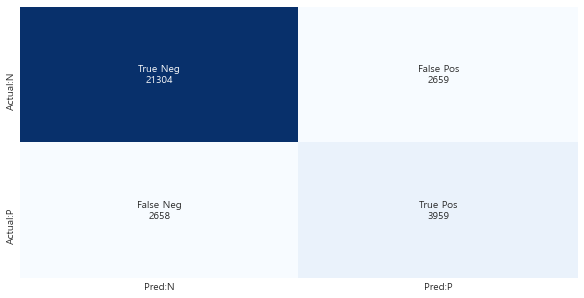

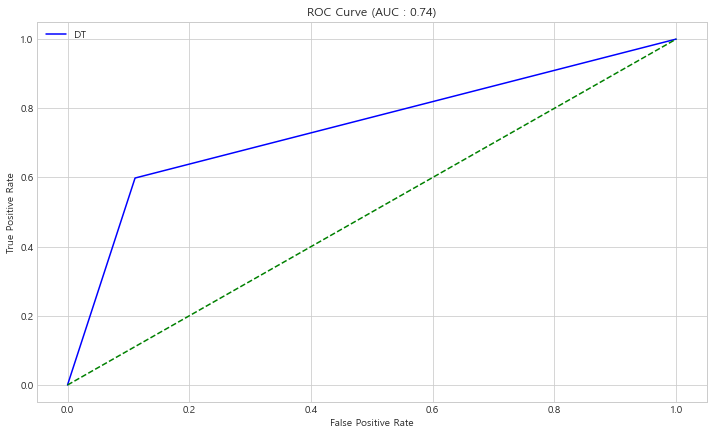

In [74]:
DT_cv(X_train, X_test, Y_train, Y_test)

In [95]:
# variable importance
rf = RandomForestClassifier()
rf.fit(X_train, Y_train)
perm = PermutationImportance(rf, scoring = "f1", random_state = 42).fit(X_test, Y_test)
eli5.show_weights(perm, top = 16, feature_names = X_test.columns.tolist())

Weight,Feature
0.2189 ± 0.0092,bias
0.1246 ± 0.0033,bias_1
0.0357 ± 0.0030,TF_ISF
0.0355 ± 0.0058,bias_2
0.0117 ± 0.0036,sent2sim
0.0088 ± 0.0063,SL
0.0057 ± 0.0032,article_len
0.0025 ± 0.0044,perc
0.0006 ± 0.0008,media_name_중부일보
0.0003 ± 0.0015,media_name_아주경제


In [101]:
def rf_cv(X_train, X_test, y_train, y_test):
    
    X_train = X_train.drop(['id', 'bias_3', 'first', 'media_name_머니투데이'], axis=1)
    X_test_id = X_test['id']
    X_test = X_test.drop(['id', 'bias_3', 'first', 'media_name_머니투데이'], axis=1)
    param_grid_rf={'criterion':["gini","entropy"] ,'max_features':['sqrt','log2'],'max_depth': [2,3,4,6]}
    rf_cv = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf,
                               cv=5, scoring = 'roc_auc', verbose=2)
    rf_cv.fit(X_train,y_train)
    print(rf_cv.best_params_)
    
    # make top 3 prob : 1 / others : 0
    rf_test_prob = rf_cv.predict_proba(X_test)[:,1]
    rf_test_prob = pd.concat([X_test_id, pd.DataFrame(rf_test_prob)], axis=1)
    rf_test_prob.columns = ['id','pred']
    
    one_list = list()
    id_list = rf_test_prob['id'].unique().tolist()
    for idd in tqdm(id_list):
        sample = rf_test_prob.loc[rf_test_prob['id'] == idd]
        one_index = sample.sort_values(by='pred', ascending=False)[:3].index.tolist()
        for ind in one_index:
            one_list.append(ind)
            
    rf_test_prob.loc[rf_test_prob.index.isin(one_list), 'pred'] = 1
    rf_test_prob.loc[~rf_test_prob.index.isin(one_list), 'pred'] = 0
    rf_test = np.array(rf_test_prob['pred'])
    
    # F1 score
    precision, recall, thresholds = precision_recall_curve(y_test, rf_test)
    auc_precision_recall = auc(recall, precision)
    print("Test:\n", "Precision score / Recall Score / F1 score(micro) / F1 score(macro) / PR-AUC / ROC-AUC \n",
          round(precision_score(y_test,rf_test, pos_label = 1),5),'         /' ,
          round(recall_score(y_test,rf_test, pos_label = 1),5),'         /' ,
          round(f1_score(y_test,rf_test, average="micro"),5),'         /' ,
          round(f1_score(y_test,rf_test, average="macro"),5),'  /' ,
          round(auc_precision_recall,5), '    /' ,
          round(roc_auc_score(y_test,rf_test),5))
    
    # confusion matrix
    test_confusion_matrix=confusion_matrix(y_test, rf_test)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    test_confusion_matrix.flatten()]
    labels = [f'{v1}\n{v2}' for v1, v2 in
              zip(group_names,group_counts)]
    labels = np.asarray(labels).reshape(2,2)
    print("Test confusion matrix")
    print('TEST ACCURACY : %.2f'%(np.mean(Y_test == rf_test)))
    sns.heatmap(test_confusion_matrix, annot=labels, fmt='', cmap="Blues",cbar=False,
                xticklabels=['Pred:N', 'Pred:P'], yticklabels=['Actual:N', 'Actual:P'])
    
    # ROC curve
    fig = plt.figure(figsize = (12, 7))
    fper, tper, thresholds = roc_curve(y_test, rf_test)
    plt.plot(fper, tper, color='blue', label='rf')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (AUC : %.2f)'%(round(roc_auc_score(y_test,rf_test),3)))
    plt.legend()

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] criterion=gini, max_depth=2, max_features=sqrt ..................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ... criterion=gini, max_depth=2, max_features=sqrt, total=   2.3s
[CV] criterion=gini, max_depth=2, max_features=sqrt ..................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV] ... criterion=gini, max_depth=2, max_features=sqrt, total=   2.4s
[CV] criterion=gini, max_depth=2, max_features=sqrt ..................
[CV] ... criterion=gini, max_depth=2, max_features=sqrt, total=   2.3s
[CV] criterion=gini, max_depth=2, max_features=sqrt ..................
[CV] ... criterion=gini, max_depth=2, max_features=sqrt, total=   2.4s
[CV] criterion=gini, max_depth=2, max_features=sqrt ..................
[CV] ... criterion=gini, max_depth=2, max_features=sqrt, total=   2.3s
[CV] criterion=gini, max_depth=2, max_features=log2 ..................
[CV] ... criterion=gini, max_depth=2, max_features=log2, total=   2.3s
[CV] criterion=gini, max_depth=2, max_features=log2 ..................
[CV] ... criterion=gini, max_depth=2, max_features=log2, total=   2.3s
[CV] criterion=gini, max_depth=2, max_features=log2 ..................
[CV] ... criterion=gini, max_depth=2, max_features=log2, total=   2.2s
[CV] criterion=gini, max_depth=2, max_features=log2 ..................
[CV] .

[CV]  criterion=entropy, max_depth=3, max_features=log2, total=   3.5s
[CV] criterion=entropy, max_depth=4, max_features=sqrt ...............
[CV]  criterion=entropy, max_depth=4, max_features=sqrt, total=   4.3s
[CV] criterion=entropy, max_depth=4, max_features=sqrt ...............
[CV]  criterion=entropy, max_depth=4, max_features=sqrt, total=   4.3s
[CV] criterion=entropy, max_depth=4, max_features=sqrt ...............
[CV]  criterion=entropy, max_depth=4, max_features=sqrt, total=   4.3s
[CV] criterion=entropy, max_depth=4, max_features=sqrt ...............
[CV]  criterion=entropy, max_depth=4, max_features=sqrt, total=   4.5s
[CV] criterion=entropy, max_depth=4, max_features=sqrt ...............
[CV]  criterion=entropy, max_depth=4, max_features=sqrt, total=   4.4s
[CV] criterion=entropy, max_depth=4, max_features=log2 ...............
[CV]  criterion=entropy, max_depth=4, max_features=log2, total=   4.4s
[CV] criterion=entropy, max_depth=4, max_features=log2 ...............
[CV]  

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  5.2min finished
  0%|                                                                                         | 0/2206 [00:00<?, ?it/s]

{'criterion': 'entropy', 'max_depth': 6, 'max_features': 'sqrt'}


100%|████████████████████████████████████████████████████████████████████████████| 2206/2206 [00:01<00:00, 1161.89it/s]


Test:
 Precision score / Recall Score / F1 score(micro) / F1 score(macro) / PR-AUC / ROC-AUC 
 0.6029          / 0.60299          / 0.82816          / 0.74665   / 0.6459     / 0.74666
Test confusion matrix
TEST ACCURACY : 0.83


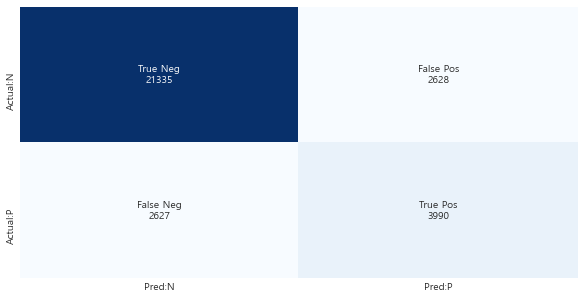

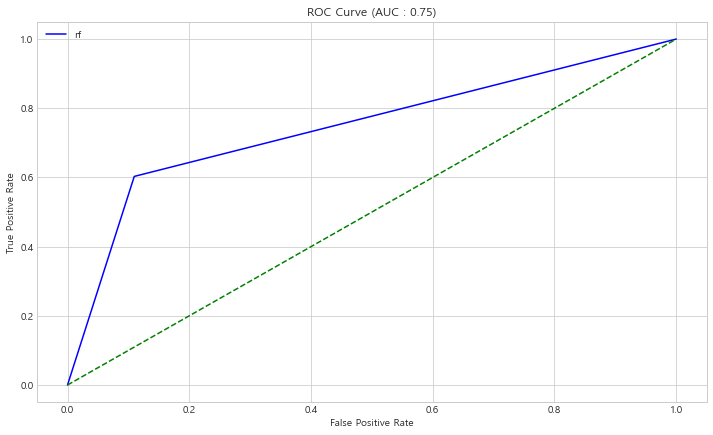

In [102]:
rf_cv(X_train, X_test, Y_train, Y_test)

In [122]:
# cov_mat=np.cov(X_train.T)
# eigen_vals,eigen_vecs=np.linalg.eig(cov_mat)
# print('Eigenvalue of X variables ! \n %s'% eigen_vals)

Eigenvalue of X variables ! 
 [1.01842474e+07 4.03219228e+01 2.26471534e-01 2.06559485e-01
 1.93782685e-01 1.65593201e-01 7.72760846e-02 9.61654212e-02
 9.47490035e-02 1.73143263e-02 7.27803221e-03 4.31437554e-03
 3.55661602e-03 1.83583140e-03 1.60298417e-05 2.50695279e-15]


In [123]:
# len(eigen_vals)

16

In [125]:
# var_exp=[(i/tot) for i in sorted(eigen_vals,reverse=True)]; var_exp

[0.9999959332618934,
 3.959228132677799e-06,
 2.223734404617185e-08,
 2.028217073188855e-08,
 1.9027610871605987e-08,
 1.6259672476973794e-08,
 9.442526906325938e-09,
 9.303448207126667e-09,
 7.587774265350492e-09,
 1.7001016584117592e-09,
 7.146333278279677e-10,
 4.2363051712021465e-10,
 3.492257618467883e-10,
 1.802611288640606e-10,
 1.5739775205111896e-12,
 2.461588463578891e-22]

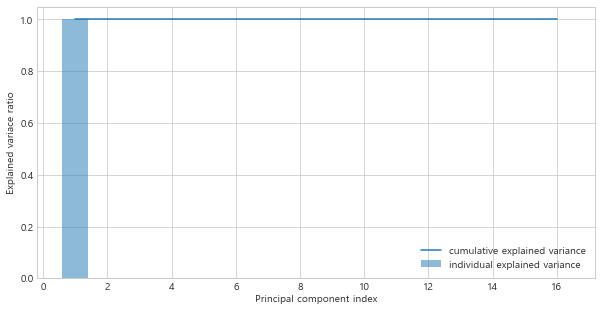

In [124]:
# ## PCA로 설명되는 분산을 계산하고 plotting!!

# tot=sum(eigen_vals)
# var_exp=[(i/tot) for i in sorted(eigen_vals,reverse=True)]

# cum_var_exp=np.cumsum(var_exp)

# plt.bar(range(1,17), var_exp, alpha=0.5, label='individual explained variance')
# plt.step(range(1,17),cum_var_exp, where='mid', label='cumulative explained variance')
# plt.ylabel('Explained variace ratio')
# plt.xlabel('Principal component index')
# plt.legend(loc='best')

In [127]:
# # 데이터 너무 커서 SVM 오래걸림,, -> 안하는 쪽으로 결론.
# variable importance

# svc = SVC()
# pca = PCA(n_components=3)
# X_train_pca = pca.fit_transform(X_train)
# X_test_pca = pca.transform(X_test)
# svc.fit(X_train_pca, Y_train)
# perm = PermutationImportance(svc, scoring = "f1", random_state = 42).fit(X_test_pca, Y_test)
# eli5.show_weights(perm, top = 16, feature_names = X_test.columns.tolist())

In [98]:
# def svm_cv(X_train, X_test, y_train, y_test):
    
#     X_train = X_train.drop(['id'], axis=1)
#     X_test_id = X_test['id']
#     X_test = X_test.drop(['id'], axis=1)
#     param_grid_svm={'C':[10**(i+1) for i in range(-2,2)], 'gamma':[10**(i+1) for i in range(-3,2)],
#                     'kernel':['linear', 'rbf','sigmoid']}
#     svm_cv = GridSearchCV(SVC(random_state=42), param_grid_svm,
#                           cv=5, scoring = 'roc_auc', verbose=2)
#     svm_cv.fit(X_train,y_train)
#     print(svm_cv.best_params_)
    
#     # make top 3 prob : 1 / others : 0
#     svm_test_prob = svm_cv.predict_proba(X_test)[:,1]
#     svm_test_prob = pd.concat([X_test_id, pd.DataFrame(svm_test_prob)], axis=1)
#     svm_test_prob.columns = ['id','pred']
    
#     one_list = list()
#     id_list = svm_test_prob['id'].unique().tolist()
#     for idd in tqdm(id_list):
#         sample = svm_test_prob.loc[svm_test_prob['id'] == idd]
#         one_index = sample.sort_values(by='pred', ascending=False)[:3].index.tolist()
#         for ind in one_index:
#             one_list.append(ind)
            
#     svm_test_prob.loc[svm_test_prob.index.isin(one_list), 'pred'] = 1
#     svm_test_prob.loc[~svm_test_prob.index.isin(one_list), 'pred'] = 0
#     svm_test = np.array(svm_test_prob['pred'])
    
#     # F1 score
#     precision, recall, thresholds = precision_recall_curve(y_test, svm_test)
#     auc_precision_recall = auc(recall, precision)
#     print("Test:\n", "Precision score / Recall Score / F1 score(micro) / F1 score(macro) / PR-AUC / ROC-AUC \n",
#           round(precision_score(y_test,svm_test, pos_label = 1),5),'         /' ,
#           round(recall_score(y_test,svm_test, pos_label = 1),5),'         /' ,
#           round(f1_score(y_test,svm_test, average="micro"),5),'         /' ,
#           round(f1_score(y_test,svm_test, average="macro"),5),'  /' ,
#           round(auc_precision_recall,5), '    /' ,
#           round(roc_auc_score(y_test,svm_test),5))
    
#     # confusion matrix
#     test_confusion_matrix=confusion_matrix(y_test, svm_test)
#     group_names = ['True Neg','False Pos','False Neg','True Pos']
#     group_counts = ['{0:0.0f}'.format(value) for value in
#                     test_confusion_matrix.flatten()]
#     labels = [f'{v1}\n{v2}' for v1, v2 in
#               zip(group_names,group_counts)]
#     labels = np.asarray(labels).reshape(2,2)
#     print("Test confusion matrix")
#     print('TEST ACCURACY : %.2f'%(np.mean(Y_test == svm_test)))
#     sns.heatmap(test_confusion_matrix, annot=labels, fmt='', cmap="Blues",cbar=False,
#                 xticklabels=['Pred:N', 'Pred:P'], yticklabels=['Actual:N', 'Actual:P'])
    
#     # ROC curve
#     fig = plt.figure(figsize = (12, 7))
#     fper, tper, thresholds = roc_curve(y_test, svm_test)
#     plt.plot(fper, tper, color='blue', label='svm')
#     plt.plot([0, 1], [0, 1], color='green', linestyle='--')
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('ROC Curve (AUC : %.2f)'%(round(roc_auc_score(y_test,svm_test),3)))
#     plt.legend()

In [99]:
# svm_cv(X_train, X_test, Y_train, Y_test)

In [106]:
# variable importance
X_train_xgb = X_train.copy()
X_train_xgb['media_name_디지털타임스'] = pd.to_numeric(X_train_xgb['media_name_디지털타임스'])
X_train_xgb['media_name_매일경제'] = pd.to_numeric(X_train_xgb['media_name_매일경제'])
X_train_xgb['media_name_머니투데이'] = pd.to_numeric(X_train_xgb['media_name_머니투데이'])
X_train_xgb['media_name_아주경제'] = pd.to_numeric(X_train_xgb['media_name_아주경제'])
X_train_xgb['media_name_중부일보'] = pd.to_numeric(X_train_xgb['media_name_중부일보'])
xgb = XGBClassifier()
xgb.fit(X_train_xgb, Y_train)
perm = PermutationImportance(xgb, scoring = "f1", random_state = 42).fit(X_test, Y_test)
eli5.show_weights(perm, top = 16, feature_names = X_test.columns.tolist())

Weight,Feature
0.3457 ± 0.0097,bias
0.0496 ± 0.0022,bias_1
0.0410 ± 0.0063,TF_ISF
0.0211 ± 0.0060,sent2sim
0.0184 ± 0.0040,article_len
0.0165 ± 0.0020,bias_2
0.0115 ± 0.0071,SL
0.0015 ± 0.0026,bias_3
0.0012 ± 0.0013,id
0.0009 ± 0.0006,first


In [120]:
# note that x_tr, y_tr is used to refit!
def xgb_cv(X_train, X_val, X_tr, X_test, y_train, y_val, y_tr, y_test):
    
    # make xgboost data type!
    to_numeric_list = ['media_name_디지털타임스','media_name_매일경제', 'media_name_머니투데이',
                       'media_name_아주경제', 'media_name_중부일보']
    
    for col in to_numeric_list:
        X_train[col] = pd.to_numeric(X_train[col])
        X_val[col] = pd.to_numeric(X_val[col])
        X_tr[col] = pd.to_numeric(X_tr[col])
        X_test[col] = pd.to_numeric(X_test[col])
    
    # drop columns by perm importance
    X_train = X_train.drop(['id', 'perc','media_name_아주경제'], axis=1)
    X_val = X_val.drop(['id', 'perc','media_name_아주경제'], axis=1)
    X_tr = X_tr.drop(['id', 'perc','media_name_아주경제'], axis=1)
    X_test_id = X_test['id']
    X_test = X_test.drop(['id', 'perc','media_name_아주경제'], axis=1)
    
    # lear도 tuning했어야 했는데,,,
    param_grid_xgb={'max_depth':range(3,7,2), 'min_child_weight':range(1,6,2),
                    'objective' : ['binary:logistic', 'binary:hinge'],
                    'n_estimators' : [500],
                    'seed' : [42]}
    
    fit_params_xgb = {'eval_metric' : 'aucpr',
                      "eval_set" : [[X_val, y_val]],
                      'early_stopping_rounds' : 50}
    
    xgb_cv = GridSearchCV(XGBClassifier(random_state=42), param_grid_xgb,
                          cv=5, scoring = 'roc_auc', verbose=2)
    xgb_cv.fit(X_train,y_train, **fit_params_xgb)
    print(xgb_cv.best_params_)
    
    # make top 3 prob : 1 / others : 0
    xgb_test_prob = xgb_cv.predict_proba(X_test)[:,1]
    xgb_test_prob = pd.concat([X_test_id, pd.DataFrame(xgb_test_prob)], axis=1)
    xgb_test_prob.columns = ['id','pred']
    
    one_list = list()
    id_list = xgb_test_prob['id'].unique().tolist()
    for idd in tqdm(id_list):
        sample = xgb_test_prob.loc[xgb_test_prob['id'] == idd]
        one_index = sample.sort_values(by='pred', ascending=False)[:3].index.tolist()
        for ind in one_index:
            one_list.append(ind)
            
    xgb_test_prob.loc[xgb_test_prob.index.isin(one_list), 'pred'] = 1
    xgb_test_prob.loc[~xgb_test_prob.index.isin(one_list), 'pred'] = 0
    xgb_test = np.array(xgb_test_prob['pred'])
    
    # F1 score
    precision, recall, thresholds = precision_recall_curve(y_test, xgb_test)
    auc_precision_recall = auc(recall, precision)
    print("Test:\n", "Precision score / Recall Score / F1 score(micro) / F1 score(macro) / PR-AUC / ROC-AUC \n",
          round(precision_score(y_test,xgb_test, pos_label = 1),5),'         /' ,
          round(recall_score(y_test,xgb_test, pos_label = 1),5),'         /' ,
          round(f1_score(y_test,xgb_test, average="micro"),5),'         /' ,
          round(f1_score(y_test,xgb_test, average="macro"),5),'  /' ,
          round(auc_precision_recall,5), '    /' ,
          round(roc_auc_score(y_test,xgb_test),5))
    
    # confusion matrix
    test_confusion_matrix=confusion_matrix(y_test, xgb_test)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    test_confusion_matrix.flatten()]
    labels = [f'{v1}\n{v2}' for v1, v2 in
              zip(group_names,group_counts)]
    labels = np.asarray(labels).reshape(2,2)
    print("Test confusion matrix")
    print('TEST ACCURACY : %.2f'%(np.mean(Y_test == xgb_test)))
    sns.heatmap(test_confusion_matrix, annot=labels, fmt='', cmap="Blues",cbar=False,
                xticklabels=['Pred:N', 'Pred:P'], yticklabels=['Actual:N', 'Actual:P'])
    
    # ROC curve
    fig = plt.figure(figsize = (12, 7))
    fper, tper, thresholds = roc_curve(y_test, xgb_test)
    plt.plot(fper, tper, color='blue', label='xgb')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (AUC : %.2f)'%(round(roc_auc_score(y_test,xgb_test),3)))
    plt.legend()

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] max_depth=3, min_child_weight=1, n_estimators=500, objective=binary:logistic, seed=42 
[0]	validation_0-aucpr:0.56937
Will train until validation_0-aucpr hasn't improved in 50 rounds.
[1]	validation_0-aucpr:0.58733
[2]	validation_0-aucpr:0.59291
[3]	validation_0-aucpr:0.59495
[4]	validation_0-aucpr:0.60314


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[5]	validation_0-aucpr:0.60404
[6]	validation_0-aucpr:0.60791
[7]	validation_0-aucpr:0.61128
[8]	validation_0-aucpr:0.61179
[9]	validation_0-aucpr:0.61159
[10]	validation_0-aucpr:0.61189
[11]	validation_0-aucpr:0.61280
[12]	validation_0-aucpr:0.61311
[13]	validation_0-aucpr:0.61472
[14]	validation_0-aucpr:0.61525
[15]	validation_0-aucpr:0.61487
[16]	validation_0-aucpr:0.61543
[17]	validation_0-aucpr:0.61572
[18]	validation_0-aucpr:0.61550
[19]	validation_0-aucpr:0.61758
[20]	validation_0-aucpr:0.61777
[21]	validation_0-aucpr:0.61780
[22]	validation_0-aucpr:0.61727
[23]	validation_0-aucpr:0.61769
[24]	validation_0-aucpr:0.61782
[25]	validation_0-aucpr:0.61810
[26]	validation_0-aucpr:0.61791
[27]	validation_0-aucpr:0.61830
[28]	validation_0-aucpr:0.61811
[29]	validation_0-aucpr:0.61840
[30]	validation_0-aucpr:0.61875
[31]	validation_0-aucpr:0.61842
[32]	validation_0-aucpr:0.61824
[33]	validation_0-aucpr:0.61825
[34]	validation_0-aucpr:0.61820
[35]	validation_0-aucpr:0.61819
[36]	validati

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[5]	validation_0-aucpr:0.60581
[6]	validation_0-aucpr:0.60973
[7]	validation_0-aucpr:0.61003
[8]	validation_0-aucpr:0.61243
[9]	validation_0-aucpr:0.61316
[10]	validation_0-aucpr:0.61343
[11]	validation_0-aucpr:0.61395
[12]	validation_0-aucpr:0.61563
[13]	validation_0-aucpr:0.61689
[14]	validation_0-aucpr:0.61781
[15]	validation_0-aucpr:0.61846
[16]	validation_0-aucpr:0.61861
[17]	validation_0-aucpr:0.61820
[18]	validation_0-aucpr:0.61796
[19]	validation_0-aucpr:0.61808
[20]	validation_0-aucpr:0.61881
[21]	validation_0-aucpr:0.61906
[22]	validation_0-aucpr:0.61925
[23]	validation_0-aucpr:0.61939
[24]	validation_0-aucpr:0.61951
[25]	validation_0-aucpr:0.61978
[26]	validation_0-aucpr:0.61977
[27]	validation_0-aucpr:0.61972
[28]	validation_0-aucpr:0.61928
[29]	validation_0-aucpr:0.61947
[30]	validation_0-aucpr:0.61947
[31]	validation_0-aucpr:0.61923
[32]	validation_0-aucpr:0.61932
[33]	validation_0-aucpr:0.61935
[34]	validation_0-aucpr:0.61923
[35]	validation_0-aucpr:0.61965
[36]	validati

[74]	validation_0-aucpr:0.61907
[75]	validation_0-aucpr:0.61889
[76]	validation_0-aucpr:0.61871
[77]	validation_0-aucpr:0.61826
[78]	validation_0-aucpr:0.61821
[79]	validation_0-aucpr:0.61829
[80]	validation_0-aucpr:0.61827
[81]	validation_0-aucpr:0.61820
[82]	validation_0-aucpr:0.61814
[83]	validation_0-aucpr:0.61825
[84]	validation_0-aucpr:0.61825
[85]	validation_0-aucpr:0.61812
[86]	validation_0-aucpr:0.61810
[87]	validation_0-aucpr:0.61810
[88]	validation_0-aucpr:0.61829
[89]	validation_0-aucpr:0.61830
[90]	validation_0-aucpr:0.61831
[91]	validation_0-aucpr:0.61853
[92]	validation_0-aucpr:0.61849
[93]	validation_0-aucpr:0.61814
[94]	validation_0-aucpr:0.61811
[95]	validation_0-aucpr:0.61815
[96]	validation_0-aucpr:0.61810
[97]	validation_0-aucpr:0.61792
[98]	validation_0-aucpr:0.61775
[99]	validation_0-aucpr:0.61772
[100]	validation_0-aucpr:0.61767
[101]	validation_0-aucpr:0.61790
[102]	validation_0-aucpr:0.61786
[103]	validation_0-aucpr:0.61776
[104]	validation_0-aucpr:0.61775
[10

[80]	validation_0-aucpr:0.49007
[81]	validation_0-aucpr:0.49018
[82]	validation_0-aucpr:0.49023
[83]	validation_0-aucpr:0.49027
[84]	validation_0-aucpr:0.49015
[85]	validation_0-aucpr:0.49027
[86]	validation_0-aucpr:0.49027
[87]	validation_0-aucpr:0.49060
[88]	validation_0-aucpr:0.49027
[89]	validation_0-aucpr:0.49035
[90]	validation_0-aucpr:0.49084
[91]	validation_0-aucpr:0.49066
[92]	validation_0-aucpr:0.48994
[93]	validation_0-aucpr:0.48987
[94]	validation_0-aucpr:0.49077
[95]	validation_0-aucpr:0.49066
[96]	validation_0-aucpr:0.49066
[97]	validation_0-aucpr:0.49073
[98]	validation_0-aucpr:0.49144
[99]	validation_0-aucpr:0.49140
[100]	validation_0-aucpr:0.49156
[101]	validation_0-aucpr:0.49141
[102]	validation_0-aucpr:0.49141
[103]	validation_0-aucpr:0.49141
[104]	validation_0-aucpr:0.49141
[105]	validation_0-aucpr:0.49171
[106]	validation_0-aucpr:0.49136
[107]	validation_0-aucpr:0.49127
[108]	validation_0-aucpr:0.49127
[109]	validation_0-aucpr:0.49146
[110]	validation_0-aucpr:0.491

[84]	validation_0-aucpr:0.48874
[85]	validation_0-aucpr:0.48914
[86]	validation_0-aucpr:0.48865
[87]	validation_0-aucpr:0.48911
[88]	validation_0-aucpr:0.48862
[89]	validation_0-aucpr:0.48923
[90]	validation_0-aucpr:0.48823
[91]	validation_0-aucpr:0.48923
[92]	validation_0-aucpr:0.48953
[93]	validation_0-aucpr:0.48973
[94]	validation_0-aucpr:0.48965
[95]	validation_0-aucpr:0.48964
[96]	validation_0-aucpr:0.48952
[97]	validation_0-aucpr:0.48993
[98]	validation_0-aucpr:0.48981
[99]	validation_0-aucpr:0.49002
[100]	validation_0-aucpr:0.48992
[101]	validation_0-aucpr:0.49002
[102]	validation_0-aucpr:0.48992
[103]	validation_0-aucpr:0.49015
[104]	validation_0-aucpr:0.48969
[105]	validation_0-aucpr:0.49007
[106]	validation_0-aucpr:0.48985
[107]	validation_0-aucpr:0.49029
[108]	validation_0-aucpr:0.49015
[109]	validation_0-aucpr:0.48974
[110]	validation_0-aucpr:0.48992
[111]	validation_0-aucpr:0.48971
[112]	validation_0-aucpr:0.48971
[113]	validation_0-aucpr:0.49010
[114]	validation_0-aucpr:0

[81]	validation_0-aucpr:0.48939
[82]	validation_0-aucpr:0.48963
[83]	validation_0-aucpr:0.48936
[84]	validation_0-aucpr:0.49040
[85]	validation_0-aucpr:0.49005
[86]	validation_0-aucpr:0.48945
[87]	validation_0-aucpr:0.49029
[88]	validation_0-aucpr:0.48996
[89]	validation_0-aucpr:0.49032
[90]	validation_0-aucpr:0.49016
[91]	validation_0-aucpr:0.49055
[92]	validation_0-aucpr:0.49055
[93]	validation_0-aucpr:0.48977
[94]	validation_0-aucpr:0.48975
[95]	validation_0-aucpr:0.49016
[96]	validation_0-aucpr:0.49015
[97]	validation_0-aucpr:0.49017
[98]	validation_0-aucpr:0.49014
Stopping. Best iteration:
[48]	validation_0-aucpr:0.49078

[CV]  max_depth=3, min_child_weight=1, n_estimators=500, objective=binary:hinge, seed=42, total=   2.4s
[CV] max_depth=3, min_child_weight=3, n_estimators=500, objective=binary:logistic, seed=42 
[0]	validation_0-aucpr:0.56937
Will train until validation_0-aucpr hasn't improved in 50 rounds.
[1]	validation_0-aucpr:0.58733
[2]	validation_0-aucpr:0.59291
[3]	valida

[41]	validation_0-aucpr:0.61935
[42]	validation_0-aucpr:0.61947
[43]	validation_0-aucpr:0.61943
[44]	validation_0-aucpr:0.61945
[45]	validation_0-aucpr:0.61939
[46]	validation_0-aucpr:0.61909
[47]	validation_0-aucpr:0.61903
[48]	validation_0-aucpr:0.61885
[49]	validation_0-aucpr:0.61884
[50]	validation_0-aucpr:0.61888
[51]	validation_0-aucpr:0.61895
[52]	validation_0-aucpr:0.61898
[53]	validation_0-aucpr:0.61912
[54]	validation_0-aucpr:0.61895
[55]	validation_0-aucpr:0.61889
[56]	validation_0-aucpr:0.61890
[57]	validation_0-aucpr:0.61890
[58]	validation_0-aucpr:0.61906
[59]	validation_0-aucpr:0.61901
[60]	validation_0-aucpr:0.61913
[61]	validation_0-aucpr:0.61897
[62]	validation_0-aucpr:0.61929
[63]	validation_0-aucpr:0.61920
[64]	validation_0-aucpr:0.61893
[65]	validation_0-aucpr:0.61875
[66]	validation_0-aucpr:0.61851
[67]	validation_0-aucpr:0.61847
[68]	validation_0-aucpr:0.61846
[69]	validation_0-aucpr:0.61870
[70]	validation_0-aucpr:0.61849
[71]	validation_0-aucpr:0.61838
[72]	val

[56]	validation_0-aucpr:0.61672
[57]	validation_0-aucpr:0.61663
[58]	validation_0-aucpr:0.61663
[59]	validation_0-aucpr:0.61659
[60]	validation_0-aucpr:0.61639
[61]	validation_0-aucpr:0.61624
[62]	validation_0-aucpr:0.61634
[63]	validation_0-aucpr:0.61646
[64]	validation_0-aucpr:0.61629
[65]	validation_0-aucpr:0.61629
[66]	validation_0-aucpr:0.61631
[67]	validation_0-aucpr:0.61675
[68]	validation_0-aucpr:0.61674
[69]	validation_0-aucpr:0.61675
[70]	validation_0-aucpr:0.61672
[71]	validation_0-aucpr:0.61654
[72]	validation_0-aucpr:0.61629
[73]	validation_0-aucpr:0.61634
[74]	validation_0-aucpr:0.61629
[75]	validation_0-aucpr:0.61629
[76]	validation_0-aucpr:0.61634
[77]	validation_0-aucpr:0.61633
[78]	validation_0-aucpr:0.61621
[79]	validation_0-aucpr:0.61640
[80]	validation_0-aucpr:0.61635
[81]	validation_0-aucpr:0.61645
[82]	validation_0-aucpr:0.61625
Stopping. Best iteration:
[32]	validation_0-aucpr:0.61731

[CV]  max_depth=3, min_child_weight=3, n_estimators=500, objective=binary:log

[10]	validation_0-aucpr:0.48430
[11]	validation_0-aucpr:0.48841
[12]	validation_0-aucpr:0.48841
[13]	validation_0-aucpr:0.48841
[14]	validation_0-aucpr:0.48881
[15]	validation_0-aucpr:0.48881
[16]	validation_0-aucpr:0.49003
[17]	validation_0-aucpr:0.48962
[18]	validation_0-aucpr:0.48962
[19]	validation_0-aucpr:0.48853
[20]	validation_0-aucpr:0.48853
[21]	validation_0-aucpr:0.46936
[22]	validation_0-aucpr:0.46936
[23]	validation_0-aucpr:0.46936
[24]	validation_0-aucpr:0.46936
[25]	validation_0-aucpr:0.46936
[26]	validation_0-aucpr:0.48787
[27]	validation_0-aucpr:0.46936
[28]	validation_0-aucpr:0.46936
[29]	validation_0-aucpr:0.46936
[30]	validation_0-aucpr:0.46934
[31]	validation_0-aucpr:0.46934
[32]	validation_0-aucpr:0.46934
[33]	validation_0-aucpr:0.46934
[34]	validation_0-aucpr:0.46934
[35]	validation_0-aucpr:0.46934
[36]	validation_0-aucpr:0.46934
[37]	validation_0-aucpr:0.46934
[38]	validation_0-aucpr:0.46934
[39]	validation_0-aucpr:0.46934
[40]	validation_0-aucpr:0.46934
[41]	val

[33]	validation_0-aucpr:0.49022
[34]	validation_0-aucpr:0.49022
[35]	validation_0-aucpr:0.48209
[36]	validation_0-aucpr:0.48072
[37]	validation_0-aucpr:0.48072
[38]	validation_0-aucpr:0.47371
[39]	validation_0-aucpr:0.47350
[40]	validation_0-aucpr:0.47291
[41]	validation_0-aucpr:0.47937
[42]	validation_0-aucpr:0.47944
[43]	validation_0-aucpr:0.47970
[44]	validation_0-aucpr:0.47370
[45]	validation_0-aucpr:0.47985
[46]	validation_0-aucpr:0.47432
[47]	validation_0-aucpr:0.47442
[48]	validation_0-aucpr:0.47429
[49]	validation_0-aucpr:0.47503
[50]	validation_0-aucpr:0.47479
[51]	validation_0-aucpr:0.47444
[52]	validation_0-aucpr:0.47447
[53]	validation_0-aucpr:0.47481
[54]	validation_0-aucpr:0.47967
[55]	validation_0-aucpr:0.47923
[56]	validation_0-aucpr:0.47936
[57]	validation_0-aucpr:0.47958
[58]	validation_0-aucpr:0.47956
[59]	validation_0-aucpr:0.48032
[60]	validation_0-aucpr:0.48042
[61]	validation_0-aucpr:0.48060
[62]	validation_0-aucpr:0.48035
[63]	validation_0-aucpr:0.47970
[64]	val

Will train until validation_0-aucpr hasn't improved in 50 rounds.
[1]	validation_0-aucpr:0.58846
[2]	validation_0-aucpr:0.59477
[3]	validation_0-aucpr:0.59652
[4]	validation_0-aucpr:0.60506
[5]	validation_0-aucpr:0.60581
[6]	validation_0-aucpr:0.60973
[7]	validation_0-aucpr:0.61003
[8]	validation_0-aucpr:0.61243
[9]	validation_0-aucpr:0.61316
[10]	validation_0-aucpr:0.61343
[11]	validation_0-aucpr:0.61395
[12]	validation_0-aucpr:0.61563
[13]	validation_0-aucpr:0.61688
[14]	validation_0-aucpr:0.61786
[15]	validation_0-aucpr:0.61801
[16]	validation_0-aucpr:0.61877
[17]	validation_0-aucpr:0.61864
[18]	validation_0-aucpr:0.61934
[19]	validation_0-aucpr:0.62005
[20]	validation_0-aucpr:0.61971
[21]	validation_0-aucpr:0.62005
[22]	validation_0-aucpr:0.62016
[23]	validation_0-aucpr:0.62031
[24]	validation_0-aucpr:0.62011
[25]	validation_0-aucpr:0.62011
[26]	validation_0-aucpr:0.62013
[27]	validation_0-aucpr:0.62020
[28]	validation_0-aucpr:0.62014
[29]	validation_0-aucpr:0.62016
[30]	validation

[69]	validation_0-aucpr:0.62074
[70]	validation_0-aucpr:0.62072
[71]	validation_0-aucpr:0.62081
[72]	validation_0-aucpr:0.62056
[73]	validation_0-aucpr:0.62055
[74]	validation_0-aucpr:0.62068
[75]	validation_0-aucpr:0.62058
[76]	validation_0-aucpr:0.62056
[77]	validation_0-aucpr:0.62063
[78]	validation_0-aucpr:0.62060
[79]	validation_0-aucpr:0.62056
[80]	validation_0-aucpr:0.62057
[81]	validation_0-aucpr:0.62067
[82]	validation_0-aucpr:0.62039
[83]	validation_0-aucpr:0.62051
[84]	validation_0-aucpr:0.62052
[85]	validation_0-aucpr:0.62032
[86]	validation_0-aucpr:0.62012
[87]	validation_0-aucpr:0.62011
[88]	validation_0-aucpr:0.61990
[89]	validation_0-aucpr:0.61983
[90]	validation_0-aucpr:0.61972
[91]	validation_0-aucpr:0.61956
[92]	validation_0-aucpr:0.61970
[93]	validation_0-aucpr:0.61947
[94]	validation_0-aucpr:0.61947
[95]	validation_0-aucpr:0.61945
[96]	validation_0-aucpr:0.61948
[97]	validation_0-aucpr:0.61924
[98]	validation_0-aucpr:0.61908
[99]	validation_0-aucpr:0.61899
[100]	va

[117]	validation_0-aucpr:0.49174
[118]	validation_0-aucpr:0.49147
[119]	validation_0-aucpr:0.49156
[120]	validation_0-aucpr:0.49146
[121]	validation_0-aucpr:0.49119
[122]	validation_0-aucpr:0.49131
[123]	validation_0-aucpr:0.49131
[124]	validation_0-aucpr:0.49113
[125]	validation_0-aucpr:0.49128
[126]	validation_0-aucpr:0.49113
[127]	validation_0-aucpr:0.49134
[128]	validation_0-aucpr:0.49110
[129]	validation_0-aucpr:0.49102
[130]	validation_0-aucpr:0.49151
[131]	validation_0-aucpr:0.49134
[132]	validation_0-aucpr:0.49157
[133]	validation_0-aucpr:0.49157
[134]	validation_0-aucpr:0.49081
[135]	validation_0-aucpr:0.49081
[136]	validation_0-aucpr:0.49111
[137]	validation_0-aucpr:0.49093
[138]	validation_0-aucpr:0.49093
[139]	validation_0-aucpr:0.49105
[140]	validation_0-aucpr:0.49078
[141]	validation_0-aucpr:0.49075
[142]	validation_0-aucpr:0.49072
[143]	validation_0-aucpr:0.49084
[144]	validation_0-aucpr:0.49075
[145]	validation_0-aucpr:0.49075
[146]	validation_0-aucpr:0.49119
[147]	vali

[32]	validation_0-aucpr:0.49022
[33]	validation_0-aucpr:0.49022
[34]	validation_0-aucpr:0.49022
[35]	validation_0-aucpr:0.48209
[36]	validation_0-aucpr:0.48072
[37]	validation_0-aucpr:0.48072
[38]	validation_0-aucpr:0.47371
[39]	validation_0-aucpr:0.47350
[40]	validation_0-aucpr:0.47291
[41]	validation_0-aucpr:0.47937
[42]	validation_0-aucpr:0.47944
[43]	validation_0-aucpr:0.47970
[44]	validation_0-aucpr:0.47370
[45]	validation_0-aucpr:0.47985
[46]	validation_0-aucpr:0.47432
[47]	validation_0-aucpr:0.47442
[48]	validation_0-aucpr:0.47429
[49]	validation_0-aucpr:0.47503
[50]	validation_0-aucpr:0.47479
[51]	validation_0-aucpr:0.47444
[52]	validation_0-aucpr:0.47447
[53]	validation_0-aucpr:0.47481
[54]	validation_0-aucpr:0.47967
[55]	validation_0-aucpr:0.47923
[56]	validation_0-aucpr:0.47936
[57]	validation_0-aucpr:0.47958
[58]	validation_0-aucpr:0.47956
[59]	validation_0-aucpr:0.48032
[60]	validation_0-aucpr:0.48042
[61]	validation_0-aucpr:0.48060
[62]	validation_0-aucpr:0.48035
[63]	val

[21]	validation_0-aucpr:0.61899
[22]	validation_0-aucpr:0.61884
[23]	validation_0-aucpr:0.61883
[24]	validation_0-aucpr:0.61862
[25]	validation_0-aucpr:0.61809
[26]	validation_0-aucpr:0.61882
[27]	validation_0-aucpr:0.61866
[28]	validation_0-aucpr:0.61816
[29]	validation_0-aucpr:0.61797
[30]	validation_0-aucpr:0.61775
[31]	validation_0-aucpr:0.61782
[32]	validation_0-aucpr:0.61725
[33]	validation_0-aucpr:0.61722
[34]	validation_0-aucpr:0.61724
[35]	validation_0-aucpr:0.61710
[36]	validation_0-aucpr:0.61717
[37]	validation_0-aucpr:0.61680
[38]	validation_0-aucpr:0.61722
[39]	validation_0-aucpr:0.61680
[40]	validation_0-aucpr:0.61676
[41]	validation_0-aucpr:0.61655
[42]	validation_0-aucpr:0.61652
[43]	validation_0-aucpr:0.61647
[44]	validation_0-aucpr:0.61645
[45]	validation_0-aucpr:0.61658
[46]	validation_0-aucpr:0.61657
[47]	validation_0-aucpr:0.61673
[48]	validation_0-aucpr:0.61670
[49]	validation_0-aucpr:0.61690
[50]	validation_0-aucpr:0.61759
[51]	validation_0-aucpr:0.61745
[52]	val

[43]	validation_0-aucpr:0.61643
[44]	validation_0-aucpr:0.61628
[45]	validation_0-aucpr:0.61656
[46]	validation_0-aucpr:0.61656
[47]	validation_0-aucpr:0.61654
[48]	validation_0-aucpr:0.61600
[49]	validation_0-aucpr:0.61603
[50]	validation_0-aucpr:0.61597
[51]	validation_0-aucpr:0.61521
[52]	validation_0-aucpr:0.61519
[53]	validation_0-aucpr:0.61500
[54]	validation_0-aucpr:0.61436
[55]	validation_0-aucpr:0.61428
[56]	validation_0-aucpr:0.61413
[57]	validation_0-aucpr:0.61378
[58]	validation_0-aucpr:0.61311
[59]	validation_0-aucpr:0.61266
[60]	validation_0-aucpr:0.61262
[61]	validation_0-aucpr:0.61189
[62]	validation_0-aucpr:0.61189
Stopping. Best iteration:
[12]	validation_0-aucpr:0.62072

[CV]  max_depth=5, min_child_weight=1, n_estimators=500, objective=binary:logistic, seed=42, total=   2.2s
[CV] max_depth=5, min_child_weight=1, n_estimators=500, objective=binary:logistic, seed=42 
[0]	validation_0-aucpr:0.59934
Will train until validation_0-aucpr hasn't improved in 50 rounds.
[1]	v

[17]	validation_0-aucpr:0.49066
[18]	validation_0-aucpr:0.49072
[19]	validation_0-aucpr:0.49092
[20]	validation_0-aucpr:0.49109
[21]	validation_0-aucpr:0.49093
[22]	validation_0-aucpr:0.49106
[23]	validation_0-aucpr:0.49088
[24]	validation_0-aucpr:0.49147
[25]	validation_0-aucpr:0.49111
[26]	validation_0-aucpr:0.49094
[27]	validation_0-aucpr:0.49130
[28]	validation_0-aucpr:0.49145
[29]	validation_0-aucpr:0.49116
[30]	validation_0-aucpr:0.49087
[31]	validation_0-aucpr:0.49177
[32]	validation_0-aucpr:0.49165
[33]	validation_0-aucpr:0.49171
[34]	validation_0-aucpr:0.49196
[35]	validation_0-aucpr:0.49120
[36]	validation_0-aucpr:0.49160
[37]	validation_0-aucpr:0.49139
[38]	validation_0-aucpr:0.49171
[39]	validation_0-aucpr:0.49174
[40]	validation_0-aucpr:0.49160
[41]	validation_0-aucpr:0.49177
[42]	validation_0-aucpr:0.49159
[43]	validation_0-aucpr:0.49196
[44]	validation_0-aucpr:0.49137
[45]	validation_0-aucpr:0.49171
[46]	validation_0-aucpr:0.49229
[47]	validation_0-aucpr:0.49211
[48]	val

[13]	validation_0-aucpr:0.62126
[14]	validation_0-aucpr:0.62066
[15]	validation_0-aucpr:0.62060
[16]	validation_0-aucpr:0.62057
[17]	validation_0-aucpr:0.62062
[18]	validation_0-aucpr:0.62066
[19]	validation_0-aucpr:0.62065
[20]	validation_0-aucpr:0.62093
[21]	validation_0-aucpr:0.62072
[22]	validation_0-aucpr:0.62044
[23]	validation_0-aucpr:0.61970
[24]	validation_0-aucpr:0.61959
[25]	validation_0-aucpr:0.61963
[26]	validation_0-aucpr:0.61989
[27]	validation_0-aucpr:0.61904
[28]	validation_0-aucpr:0.61880
[29]	validation_0-aucpr:0.61877
[30]	validation_0-aucpr:0.61848
[31]	validation_0-aucpr:0.61864
[32]	validation_0-aucpr:0.61863
[33]	validation_0-aucpr:0.61798
[34]	validation_0-aucpr:0.61771
[35]	validation_0-aucpr:0.61773
[36]	validation_0-aucpr:0.61704
[37]	validation_0-aucpr:0.61757
[38]	validation_0-aucpr:0.61780
[39]	validation_0-aucpr:0.61782
[40]	validation_0-aucpr:0.61756
[41]	validation_0-aucpr:0.61735
[42]	validation_0-aucpr:0.61719
[43]	validation_0-aucpr:0.61720
[44]	val

[46]	validation_0-aucpr:0.49000
[47]	validation_0-aucpr:0.49012
[48]	validation_0-aucpr:0.49007
[49]	validation_0-aucpr:0.48989
[50]	validation_0-aucpr:0.49033
[51]	validation_0-aucpr:0.48968
[52]	validation_0-aucpr:0.48998
[53]	validation_0-aucpr:0.49030
[54]	validation_0-aucpr:0.49021
[55]	validation_0-aucpr:0.49045
[56]	validation_0-aucpr:0.49039
[57]	validation_0-aucpr:0.49030
[58]	validation_0-aucpr:0.49015
[59]	validation_0-aucpr:0.48951
[60]	validation_0-aucpr:0.49015
[61]	validation_0-aucpr:0.49038
[62]	validation_0-aucpr:0.49032
[63]	validation_0-aucpr:0.49032
[64]	validation_0-aucpr:0.48957
[65]	validation_0-aucpr:0.48984
[66]	validation_0-aucpr:0.48981
[67]	validation_0-aucpr:0.49001
[68]	validation_0-aucpr:0.49040
[69]	validation_0-aucpr:0.49019
[70]	validation_0-aucpr:0.49043
[71]	validation_0-aucpr:0.49037
[72]	validation_0-aucpr:0.49040
[73]	validation_0-aucpr:0.49031
[74]	validation_0-aucpr:0.48992
[75]	validation_0-aucpr:0.49019
[76]	validation_0-aucpr:0.48971
[77]	val

[11]	validation_0-aucpr:0.48852
[12]	validation_0-aucpr:0.48866
[13]	validation_0-aucpr:0.48923
[14]	validation_0-aucpr:0.49071
[15]	validation_0-aucpr:0.49026
[16]	validation_0-aucpr:0.49068
[17]	validation_0-aucpr:0.49089
[18]	validation_0-aucpr:0.49102
[19]	validation_0-aucpr:0.49119
[20]	validation_0-aucpr:0.49121
[21]	validation_0-aucpr:0.49139
[22]	validation_0-aucpr:0.49130
[23]	validation_0-aucpr:0.49130
[24]	validation_0-aucpr:0.49127
[25]	validation_0-aucpr:0.49144
[26]	validation_0-aucpr:0.49139
[27]	validation_0-aucpr:0.49145
[28]	validation_0-aucpr:0.49145
[29]	validation_0-aucpr:0.49120
[30]	validation_0-aucpr:0.49137
[31]	validation_0-aucpr:0.49102
[32]	validation_0-aucpr:0.49105
[33]	validation_0-aucpr:0.49108
[34]	validation_0-aucpr:0.49027
[35]	validation_0-aucpr:0.49027
[36]	validation_0-aucpr:0.49027
[37]	validation_0-aucpr:0.49036
[38]	validation_0-aucpr:0.49083
[39]	validation_0-aucpr:0.49041
[40]	validation_0-aucpr:0.49065
[41]	validation_0-aucpr:0.49055
[42]	val

[35]	validation_0-aucpr:0.61782
[36]	validation_0-aucpr:0.61726
[37]	validation_0-aucpr:0.61708
[38]	validation_0-aucpr:0.61709
[39]	validation_0-aucpr:0.61687
[40]	validation_0-aucpr:0.61663
[41]	validation_0-aucpr:0.61643
[42]	validation_0-aucpr:0.61604
[43]	validation_0-aucpr:0.61566
[44]	validation_0-aucpr:0.61525
[45]	validation_0-aucpr:0.61505
[46]	validation_0-aucpr:0.61474
[47]	validation_0-aucpr:0.61458
[48]	validation_0-aucpr:0.61443
[49]	validation_0-aucpr:0.61417
[50]	validation_0-aucpr:0.61415
[51]	validation_0-aucpr:0.61396
[52]	validation_0-aucpr:0.61395
[53]	validation_0-aucpr:0.61381
[54]	validation_0-aucpr:0.61325
[55]	validation_0-aucpr:0.61329
[56]	validation_0-aucpr:0.61323
[57]	validation_0-aucpr:0.61317
[58]	validation_0-aucpr:0.61316
[59]	validation_0-aucpr:0.61327
[60]	validation_0-aucpr:0.61302
[61]	validation_0-aucpr:0.61294
[62]	validation_0-aucpr:0.61303
[63]	validation_0-aucpr:0.61306
[64]	validation_0-aucpr:0.61302
[65]	validation_0-aucpr:0.61299
[66]	val

[63]	validation_0-aucpr:0.61724
[64]	validation_0-aucpr:0.61722
[65]	validation_0-aucpr:0.61713
Stopping. Best iteration:
[15]	validation_0-aucpr:0.62118

[CV]  max_depth=5, min_child_weight=5, n_estimators=500, objective=binary:logistic, seed=42, total=   2.3s
[CV] max_depth=5, min_child_weight=5, n_estimators=500, objective=binary:logistic, seed=42 
[0]	validation_0-aucpr:0.59934
Will train until validation_0-aucpr hasn't improved in 50 rounds.
[1]	validation_0-aucpr:0.60668
[2]	validation_0-aucpr:0.61115
[3]	validation_0-aucpr:0.61252
[4]	validation_0-aucpr:0.61341
[5]	validation_0-aucpr:0.61401
[6]	validation_0-aucpr:0.61500
[7]	validation_0-aucpr:0.61659
[8]	validation_0-aucpr:0.61822
[9]	validation_0-aucpr:0.61807
[10]	validation_0-aucpr:0.61835
[11]	validation_0-aucpr:0.61918
[12]	validation_0-aucpr:0.61830
[13]	validation_0-aucpr:0.61819
[14]	validation_0-aucpr:0.61881
[15]	validation_0-aucpr:0.61890
[16]	validation_0-aucpr:0.61818
[17]	validation_0-aucpr:0.61803
[18]	validatio

[21]	validation_0-aucpr:0.49113
[22]	validation_0-aucpr:0.49087
[23]	validation_0-aucpr:0.49092
[24]	validation_0-aucpr:0.48984
[25]	validation_0-aucpr:0.49012
[26]	validation_0-aucpr:0.48986
[27]	validation_0-aucpr:0.48989
[28]	validation_0-aucpr:0.48976
[29]	validation_0-aucpr:0.49049
[30]	validation_0-aucpr:0.49075
[31]	validation_0-aucpr:0.49041
[32]	validation_0-aucpr:0.49075
[33]	validation_0-aucpr:0.49099
[34]	validation_0-aucpr:0.49087
[35]	validation_0-aucpr:0.49055
[36]	validation_0-aucpr:0.49040
[37]	validation_0-aucpr:0.49065
[38]	validation_0-aucpr:0.49048
[39]	validation_0-aucpr:0.49039
[40]	validation_0-aucpr:0.49024
[41]	validation_0-aucpr:0.49038
[42]	validation_0-aucpr:0.49058
[43]	validation_0-aucpr:0.49063
[44]	validation_0-aucpr:0.49058
[45]	validation_0-aucpr:0.49038
[46]	validation_0-aucpr:0.49043
[47]	validation_0-aucpr:0.49043
[48]	validation_0-aucpr:0.49060
[49]	validation_0-aucpr:0.48949
[50]	validation_0-aucpr:0.48937
[51]	validation_0-aucpr:0.48957
[52]	val

[47]	validation_0-aucpr:0.49215
[48]	validation_0-aucpr:0.49240
[49]	validation_0-aucpr:0.49227
[50]	validation_0-aucpr:0.49205
[51]	validation_0-aucpr:0.49214
[52]	validation_0-aucpr:0.49171
[53]	validation_0-aucpr:0.49165
[54]	validation_0-aucpr:0.49157
[55]	validation_0-aucpr:0.49136
[56]	validation_0-aucpr:0.49159
[57]	validation_0-aucpr:0.49206
[58]	validation_0-aucpr:0.49200
[59]	validation_0-aucpr:0.49196
[60]	validation_0-aucpr:0.49196
[61]	validation_0-aucpr:0.49205
[62]	validation_0-aucpr:0.49190
[63]	validation_0-aucpr:0.49193
[64]	validation_0-aucpr:0.49193
[65]	validation_0-aucpr:0.49193
[66]	validation_0-aucpr:0.49192
[67]	validation_0-aucpr:0.49214
[68]	validation_0-aucpr:0.49203
[69]	validation_0-aucpr:0.49191
[70]	validation_0-aucpr:0.49176
[71]	validation_0-aucpr:0.49208
Stopping. Best iteration:
[21]	validation_0-aucpr:0.49282

[CV]  max_depth=5, min_child_weight=5, n_estimators=500, objective=binary:hinge, seed=42, total=   2.6s
[0]	validation_0-aucpr:0.56959
Will t

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  2.6min finished


[3]	validation_0-aucpr:0.60256
[4]	validation_0-aucpr:0.60368
[5]	validation_0-aucpr:0.60403
[6]	validation_0-aucpr:0.60535
[7]	validation_0-aucpr:0.61173
[8]	validation_0-aucpr:0.61228
[9]	validation_0-aucpr:0.61294
[10]	validation_0-aucpr:0.61335
[11]	validation_0-aucpr:0.61545
[12]	validation_0-aucpr:0.61490
[13]	validation_0-aucpr:0.61518
[14]	validation_0-aucpr:0.61519
[15]	validation_0-aucpr:0.61569
[16]	validation_0-aucpr:0.61513
[17]	validation_0-aucpr:0.61521
[18]	validation_0-aucpr:0.61674
[19]	validation_0-aucpr:0.61721
[20]	validation_0-aucpr:0.61783
[21]	validation_0-aucpr:0.61814
[22]	validation_0-aucpr:0.61799
[23]	validation_0-aucpr:0.61826
[24]	validation_0-aucpr:0.61852
[25]	validation_0-aucpr:0.61801
[26]	validation_0-aucpr:0.61810
[27]	validation_0-aucpr:0.61839
[28]	validation_0-aucpr:0.61860
[29]	validation_0-aucpr:0.61817
[30]	validation_0-aucpr:0.61791
[31]	validation_0-aucpr:0.61796
[32]	validation_0-aucpr:0.61769
[33]	validation_0-aucpr:0.61772
[34]	validation

  0%|                                                                                         | 0/2206 [00:00<?, ?it/s]

{'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 500, 'objective': 'binary:logistic', 'seed': 42}


100%|████████████████████████████████████████████████████████████████████████████| 2206/2206 [00:02<00:00, 1086.97it/s]


Test:
 Precision score / Recall Score / F1 score(micro) / F1 score(macro) / PR-AUC / ROC-AUC 
 0.60396          / 0.60405          / 0.82861          / 0.74732   / 0.64684     / 0.74734
Test confusion matrix
TEST ACCURACY : 0.83


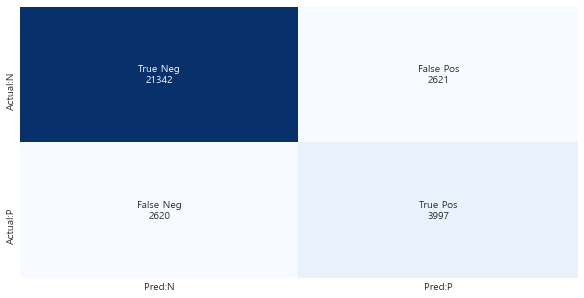

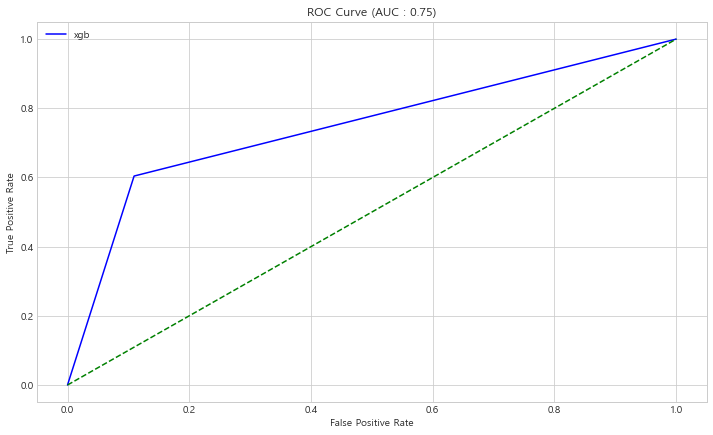

In [121]:
xgb_cv(train_x, val_x, X_train, X_test, train_y, val_y, Y_train, Y_test)

## RESULT

In [130]:
# Test:
#  Precision score / Recall Score / F1 score(micro) / F1 score(macro) / PR-AUC / ROC-AUC 
#  0.59202          / 0.59211          / 0.82345          / 0.73971   / 0.6362     / 0.73972
# Test confusion matrix
# TEST ACCURACY : 0.82

# Test:
#  Precision score / Recall Score / F1 score(micro) / F1 score(macro) / PR-AUC / ROC-AUC 
#  0.59822          / 0.59831          / 0.82613          / 0.74366   / 0.64172     / 0.74367
# Test confusion matrix
# TEST ACCURACY : 0.83

# Test:
#  Precision score / Recall Score / F1 score(micro) / F1 score(macro) / PR-AUC / ROC-AUC 
#  0.6029          / 0.60299          / 0.82816          / 0.74665   / 0.6459     / 0.74666
# Test confusion matrix
# TEST ACCURACY : 0.83

# Test:
#  Precision score / Recall Score / F1 score(micro) / F1 score(macro) / PR-AUC / ROC-AUC 
#  0.60396          / 0.60405          / 0.82861          / 0.74732   / 0.64684     / 0.74734
# Test confusion matrix
# TEST ACCURACY : 0.83
    
model = ['Logistic Regression','DecisionTree','RandomForest', 'XGBoost']
score1 = [0.82,0.83,0.83,0.83]
score2 = [0.59202,0.59822,0.6029,0.60396]
score3 = [0.59211, 0.59831, 0.60299, 0.60405]
score4 = [0.82345, 0.82613, 0.82816, 0.82861]
score5 = [0.73971, 0.74366, 0.74665, 0.74732]
score6 = [0.73972, 0.74367, 0.74666, 0.74734]
result = pd.DataFrame({'Model':model,
                        'Accuracy':score1,'Precision':score2,'Recall':score3,
                        'F1_Score(micro)':score4, 'F1_Score(macro)':score5, 'ROC-AUC':score6})
result.T

,0,1,2,3
Model,Logistic Regression,DecisionTree,RandomForest,XGBoost
Accuracy,0.82,0.83,0.83,0.83
Precision,0.59202,0.59822,0.6029,0.60396
Recall,0.59211,0.59831,0.60299,0.60405
F1_Score(micro),0.82345,0.82613,0.82816,0.82861
F1_Score(macro),0.73971,0.74366,0.74665,0.74732
ROC-AUC,0.73972,0.74367,0.74666,0.74734


In [133]:
result

,Model,Accuracy,Precision,Recall,F1_Score(micro),F1_Score(macro),ROC-AUC
0,Logistic Regression,0.82,0.59202,0.59211,0.82345,0.73971,0.73972
1,DecisionTree,0.83,0.59822,0.59831,0.82613,0.74366,0.74367
2,RandomForest,0.83,0.60290,0.60299,0.82816,0.74665,0.74666
3,XGBoost,0.83,0.60396,0.60405,0.82861,0.74732,0.74734


In [134]:
result.columns

Index(['Model', 'Accuracy', 'Precision', 'Recall', 'F1_Score(micro)',
       'F1_Score(macro)', 'ROC-AUC'],
      dtype='object')

In [ ]:

fig = plt.figure(figsize= (24, 8*6))
for i, col in tqdm(enumerate(conti_list)):
    plt.subplot(5, 2, i+1)
    plt.subplots_adjust(wspace=0.2, hspace=0.6)
    sns.distplot(X_train[col], hist = False, kde = True)
    plt.title( 'Plot of %s (skewness : %.2f)'%(col, skew(X_train[col])) )

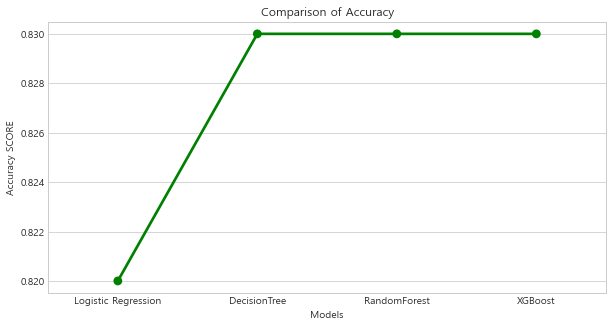

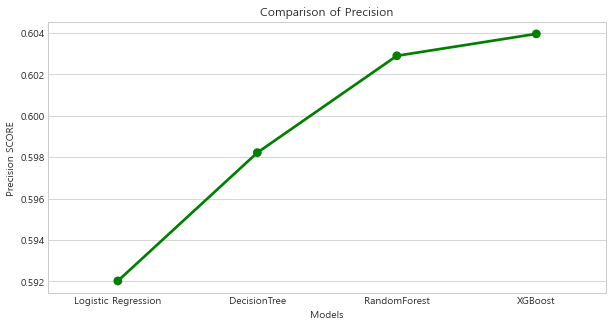

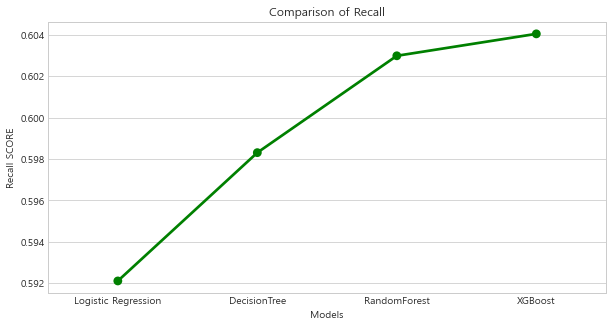

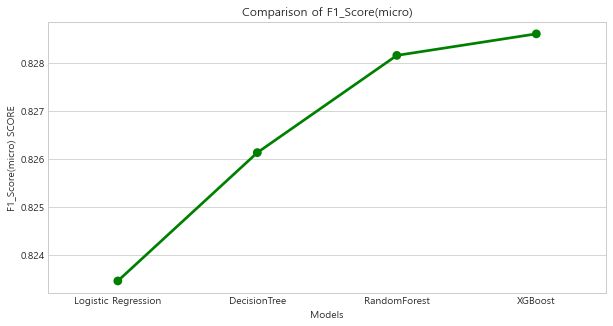

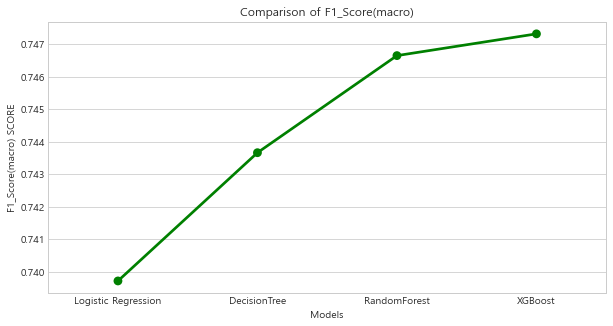

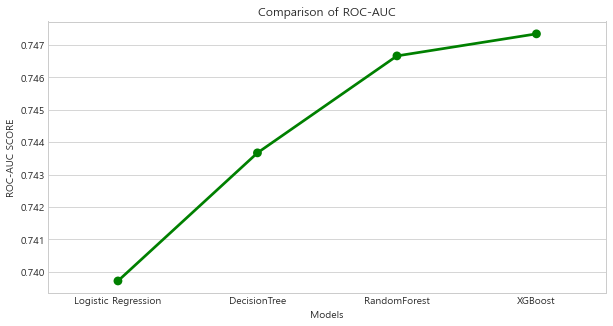

In [152]:
result_col = ['Accuracy', 'Precision', 'Recall', 'F1_Score(micro)', 'F1_Score(macro)', 'ROC-AUC']


# fig = plt.figure(figsize = (27,18))

for i, col in enumerate(result_col):
#     plt.subplot(2, 3, (i+1))
    plt.subplots_adjust(wspace=0.2, hspace=0.6)
    sns.pointplot(x=result['Model'], y=result[col], color='g')
    plt.title('Comparison of %s'%(col))
    plt.xlabel('Models')
    plt.ylabel('%s SCORE'%(col))
    plt.show()

# sns.pointplot(x='Model',y='F1_Score(micro)',data=result, color="r")
# sns.pointplot(x='Model',y='F1_Score(macro)',data=result, color="g")
# sns.pointplot(x='Model',y='AUC-PR',data=result, color="b")
# sns.pointplot(x='Model',y='ROC-AUC',data=result, color="g")